## Tesis de Grado Machine Learning

- Alexis Carrera


## Cargar Base De Datos

## Instalar e importar bibliotecas


In [1]:
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, RichProgressBar
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pytorch_lightning.loggers import CSVLogger
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
# from pytorch_forecasting.data import GroupNormalizer
# from pytorch_forecasting.metrics import MAE
# from pytorch_forecasting.data import NaNLabelEncoder
# from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, RichProgressBar
# from pytorch_lightning.loggers import CSVLogger
# import torch

## PARAMETROS

In [2]:
# Configuración
TICKER_DIR = "./data_final_v3"  # Directorio donde están los archivos CSV
LOOKBACK = 60      # Ventana de lookback para las secuencias Reviso 3 meses
PREDICTION_HORIZON = 1  # Predecir 3 meses (60 dias habiles)
BATCH_SIZE = 128
HIDDEN_SIZE = 128
NUM_LAYERS = 3
DROPOUT = 0.1
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
N_HEAD = 4
NUM_WORKERS = 0
STEP_SIZE = 3

MAXIMA_RENTABILIDAD = 40.0

## Procesamiento de Datos

# Filtro maximo rentabilidad 40 para poder omitir datos muy altos

# FILTRO DE SOLO SERVICIOS FINANCIEROS QUE SON LAS EMPRESAS QUE MAS EXISTEN EN EL S&P500

In [3]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import os

class StockDataset(Dataset):
    def __init__(self, ticker_files, lookback=LOOKBACK, prediction_horizon=PREDICTION_HORIZON, step_size=STEP_SIZE):
        """
        Dataset que carga datos bajo demanda para ahorrar RAM

        Args:
            ticker_files: Lista de archivos CSV de tickers
            lookback: Días históricos para cada secuencia
            prediction_horizon: Horizonte de predicción
            step_size: Saltos entre secuencias
        """
        self.lookback = lookback
        self.prediction_horizon = prediction_horizon
        self.step_size = step_size
        self.ticker_files = ticker_files

        # Pre-calcular índices y metadatos sin cargar todos los datos
        self.indices = []  # (ticker_index, start_index) para cada secuencia
        self.scalers = {}
        self.ticker_dfs = {}  # Cache para DataFrames ya cargados
        self.ticker_features = {}  # Cache para features escalados

        self._precompute_indices()

    def _precompute_indices(self):
        """Pre-calcula todos los índices válidos sin cargar datos completos"""
        total_sequences = 0

        for ticker_idx, ticker_file in enumerate(self.ticker_files):
            try:
                # Cargar solo para obtener metadatos
                df = pd.read_csv(ticker_file, nrows=100)  # Solo leer primeras filas para estructura

                if 'Target_3M_Return' not in df.columns:
                    print(f"Saltando {ticker_file}: no tiene Target_3M_Return")
                    continue


                # Leer todo el archivo (una sola vez)
                df = pd.read_csv(ticker_file)
                df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
                df = df.sort_values('Date').reset_index(drop=True)

                total_rows = len(df)

                # Calcular índices válidos para este ticker
                valid_indices = range(
                    self.lookback,
                    total_rows - self.prediction_horizon,
                    self.step_size
                )

                added = 0
                for start_idx in valid_indices:
                    end_idx = start_idx + self.prediction_horizon - 1

                    # Si se sale del rango, romper el bucle
                    if end_idx >= total_rows:
                        break

                    target_value = df['Target_3M_Return'].iloc[end_idx]

                    # Saltar secuencias con target demasiado alto
                    if target_value > MAXIMA_RENTABILIDAD or pd.isna(target_value):
                        continue

                    # Guardar secuencia válida
                    self.indices.append((ticker_idx, start_idx))
                    added += 1

                total_sequences += added

                # # Almacenar metadatos
                # for start_idx in valid_indices:
                #     self.indices.append((ticker_idx, start_idx))

                # total_sequences += len(valid_indices)
                # print(f"Ticker {ticker_file}: {len(valid_indices)} secuencias potenciales")

            except Exception as e:
                print(f"Error procesando {ticker_file}: {e}")
                continue

    def _load_ticker_data(self, ticker_idx):
        """Carga y procesa datos de un ticker específico (con cache)"""
        if ticker_idx in self.ticker_dfs:
            return self.ticker_dfs[ticker_idx], self.ticker_features[ticker_idx]

        ticker_file = self.ticker_files[ticker_idx]

        # Cargar DataFrame completo
        df = pd.read_csv(ticker_file)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)

        # Extraer features
        features = df.drop(['Date', 'Target_Direction', 'Target_3M_Return'],
                          axis=1, errors='ignore')

        # Escalar
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        # Guardar en cache
        self.ticker_dfs[ticker_idx] = df
        self.ticker_features[ticker_idx] = features_scaled
        self.scalers[ticker_idx] = scaler

        return df, features_scaled

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Obtener metadatos de la secuencia
        ticker_idx, start_idx = self.indices[idx]

        # Cargar datos del ticker (se cachean después de primera carga)
        df, features_scaled = self._load_ticker_data(ticker_idx)

        # Extraer secuencia
        end_idx = start_idx
        start_seq_idx = end_idx - self.lookback


        seq = features_scaled[start_seq_idx:end_idx]

        target = df['Target_3M_Return'].iloc[end_idx + self.prediction_horizon - 1]

        # print(f"Ticker {ticker_idx} : start_seq_idx {start_seq_idx}, end_idx {end_idx}, target {target}")

        # Convertir a tensores
        seq_tensor = torch.FloatTensor(seq)
        target_tensor = torch.FloatTensor([target])

        return seq_tensor, target_tensor

    def clear_cache(self):
        """Liberar memoria del cache"""
        self.ticker_dfs.clear()
        self.ticker_features.clear()
        self.scalers.clear()


In [4]:
# import torch
# from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# import pytorch_lightning as pl
# import os

# class StockDataset(Dataset):
#     def __init__(self, ticker_files, lookback=LOOKBACK, prediction_horizon=PREDICTION_HORIZON, step_size=STEP_SIZE):
#         self.lookback = lookback
#         self.prediction_horizon = prediction_horizon
#         self.step_size = step_size
#         self.ticker_files = ticker_files

#         self.indices = []  # (ticker_index, start_index)
#         self.scalers = {}
#         self.ticker_dfs = {}
#         self.ticker_features = {}

#         self._precompute_indices()

#     def _precompute_indices(self):
#         total_sequences = 0
#         for ticker_idx, ticker_file in enumerate(self.ticker_files):
#             try:
#                 df = pd.read_csv(ticker_file)
#                 if 'Target_3M_Return' not in df.columns:
#                     print(f"Saltando {ticker_file}: no tiene Target_3M_Return")
#                     continue

#                 df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
#                 df = df.sort_values('Date').reset_index(drop=True)

#                 total_rows = len(df)
#                 valid_indices = range(
#                     self.lookback,
#                     total_rows - self.prediction_horizon,
#                     self.step_size
#                 )

#                 for start_idx in valid_indices:
#                     end_idx = start_idx + self.prediction_horizon - 1
#                     if end_idx >= total_rows:
#                         break
#                     target_value = df['Target_3M_Return'].iloc[end_idx]
#                     if pd.isna(target_value):
#                         continue
#                     self.indices.append((ticker_idx, start_idx))

#                 total_sequences += len(valid_indices)

#             except Exception as e:
#                 print(f"Error procesando {ticker_file}: {e}")
#                 continue

#     def _load_ticker_data(self, ticker_idx):
#         if ticker_idx in self.ticker_dfs:
#             return self.ticker_dfs[ticker_idx], self.ticker_features[ticker_idx]

#         ticker_file = self.ticker_files[ticker_idx]
#         df = pd.read_csv(ticker_file)
#         df['Date'] = pd.to_datetime(df['Date'])
#         df = df.sort_values('Date').reset_index(drop=True)

#         features = df.drop(['Date', 'Target_Direction', 'Target_3M_Return'],
#                            axis=1, errors='ignore')
#         scaler = StandardScaler()
#         features_scaled = scaler.fit_transform(features)

#         self.ticker_dfs[ticker_idx] = df
#         self.ticker_features[ticker_idx] = features_scaled
#         self.scalers[ticker_idx] = scaler
#         return df, features_scaled

#     def __len__(self):
#         return len(self.indices)

#     def __getitem__(self, idx):
#         ticker_idx, start_idx = self.indices[idx]
#         df, features_scaled = self._load_ticker_data(ticker_idx)
#         end_idx = start_idx
#         start_seq_idx = end_idx - self.lookback
#         seq = features_scaled[start_seq_idx:end_idx]
#         target = df['Target_3M_Return'].iloc[end_idx + self.prediction_horizon - 1]
#         return torch.FloatTensor(seq), torch.FloatTensor([target])

#     def clear_cache(self):
#         self.ticker_dfs.clear()
#         self.ticker_features.clear()
#         self.scalers.clear()



In [5]:
from torch.utils.data import ConcatDataset, random_split, DataLoader

class StockDataModule(pl.LightningDataModule):
    def __init__(self, ticker_files, lookback=LOOKBACK, prediction_horizon=PREDICTION_HORIZON, batch_size=BATCH_SIZE, exclude_sector = 'Sector_technology'):
        super().__init__()
        self.ticker_files = self._filter_by_sector(ticker_files, exclude_sector)
        self.lookback = lookback
        self.prediction_horizon = prediction_horizon
        self.batch_size = batch_size

    def _filter_by_sector(self, ticker_files, exclude_sector="Sector_technology"):
        """
        Filtra los tickers cuyo sector tenga 1 en la columna 'exclude_sector' (por ejemplo 'Sector_technology').

        Args:
            ticker_files: lista de rutas CSV de tickers
            exclude_sector: nombre de la columna de sector a excluir (ej. 'Sector_technology')
        """
        filtered = []
        for f in ticker_files:
            if  f == "./data_final_v3/GOOGL_completo_arreglado.csv" or f == "./data_final_v3/GOOG_completo_arreglado.csv" or f == "./data_final_v3/AMZN_completo_arreglado.csv" or f == "./data_final_v3/META_completo_arreglado.csv" or f == "./data_final_v3/TSLA_completo_arreglado.csv":
              continue # excluir si pertenece a las big 5 ademas de technology
            try:
                df = pd.read_csv(f, nrows=1)  # leer solo la primera fila para detectar el sector
                if exclude_sector in df.columns:
                    # Tomar el valor de la primera fila en esa columna
                    sector_flag = df[exclude_sector].iloc[0]
                    if sector_flag == 1:
                        continue  # excluir si pertenece a ese sector
                filtered.append(f)
            except Exception as e:
                print(f"⚠️ Error leyendo {f}: {e}")
                continue

        print(f"✅ Tickers incluidos tras filtro de sector (excluyendo {exclude_sector}): {len(filtered)}")
        return filtered

    def setup(self, stage=None):
        train_datasets = []
        val_datasets = []
        test_datasets = []

        for file in self.ticker_files:
            # Dataset de un solo ticker
            dataset = StockDataset([file], self.lookback, self.prediction_horizon)
            n = len(dataset)
            if n < 3:
                continue  # evita errores con series demasiado cortas

            train_size = int(n * TRAIN_RATIO)
            val_size = int(n * VAL_RATIO)
            test_size = n - train_size - val_size

            train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
            train_datasets.append(train_ds)
            val_datasets.append(val_ds)
            test_datasets.append(test_ds)

        # Combinar pero manteniendo independencia por ticker
        self.train_dataset = ConcatDataset(train_datasets)
        self.val_dataset = ConcatDataset(val_datasets)
        self.test_dataset = ConcatDataset(test_datasets)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=NUM_WORKERS)


In [6]:

# # -------------------------------
# # 🔹 NUEVO: DataModule mejorado
# # -------------------------------
# class StockDataModule(pl.LightningDataModule):
#     def __init__(self, ticker_files, lookback=LOOKBACK, prediction_horizon=PREDICTION_HORIZON, batch_size=BATCH_SIZE,
#                  train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO, num_workers=NUM_WORKERS, exclude_sector = 'Sector_technology'):
#         super().__init__()
#         self.ticker_files = self._filter_by_sector(ticker_files, exclude_sector)
#         self.lookback = lookback
#         self.prediction_horizon = prediction_horizon
#         self.batch_size = batch_size
#         self.train_ratio = train_ratio
#         self.val_ratio = val_ratio
#         self.num_workers = num_workers

#     def _filter_by_sector(self, ticker_files, exclude_sector="Sector_technology"):
#         """
#         Filtra los tickers cuyo sector tenga 1 en la columna 'exclude_sector' (por ejemplo 'Sector_technology').

#         Args:
#             ticker_files: lista de rutas CSV de tickers
#             exclude_sector: nombre de la columna de sector a excluir (ej. 'Sector_technology')
#         """
#         filtered = []
#         for f in ticker_files:
#             try:
#                 df = pd.read_csv(f, nrows=1)  # leer solo la primera fila para detectar el sector
#                 if exclude_sector in df.columns:
#                     # Tomar el valor de la primera fila en esa columna
#                     sector_flag = df[exclude_sector].iloc[0]
#                     if sector_flag == 1:
#                         continue  # excluir si pertenece a ese sector
#                 filtered.append(f)
#             except Exception as e:
#                 print(f"⚠️ Error leyendo {f}: {e}")
#                 continue

#         print(f"✅ Tickers incluidos tras filtro de sector (excluyendo {exclude_sector}): {len(filtered)}")
#         return filtered


#     def setup(self, stage=None):
#         train_datasets, val_datasets, test_datasets = [], [], []

#         for file in self.ticker_files:
#             dataset = StockDataset([file], self.lookback, self.prediction_horizon)
#             n = len(dataset)
#             if n < 3:
#                 continue

#             # 🔸 División temporal: los últimos lotes son test
#             test_size = int(n * (1 - self.train_ratio - self.val_ratio))
#             val_size = int(n * self.val_ratio)
#             train_size = n - val_size - test_size

#             indices = np.arange(n)
#             train_idx = indices[:train_size]
#             val_idx = indices[train_size:train_size + val_size]
#             test_idx = indices[train_size + val_size:]

#             from torch.utils.data import Subset
#             train_ds = Subset(dataset, train_idx)
#             val_ds = Subset(dataset, val_idx)
#             test_ds = Subset(dataset, test_idx)

#             train_datasets.append(train_ds)
#             val_datasets.append(val_ds)
#             test_datasets.append(test_ds)

#         self.train_dataset = ConcatDataset(train_datasets)
#         self.val_dataset = ConcatDataset(val_datasets)
#         self.test_dataset = ConcatDataset(test_datasets)

#     def train_dataloader(self):
#         return DataLoader(self.train_dataset, batch_size=self.batch_size,
#                           shuffle=True, num_workers=self.num_workers)

#     def val_dataloader(self):
#         return DataLoader(self.val_dataset, batch_size=self.batch_size,
#                           num_workers=self.num_workers)

#     def test_dataloader(self):
#         # 🔹 NO se mezcla el orden (importante en test temporal)
#         return DataLoader(self.test_dataset, batch_size=self.batch_size,
#                           shuffle=False, num_workers=self.num_workers)


# OMITIR ESTO

In [7]:
# import torch
# from torch.utils.data import Dataset
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# import pytorch_lightning as pl
# from torch.utils.data import DataLoader, random_split
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import numpy as np
# import os

# class StockDataset(Dataset):
#     def __init__(self, ticker_files, lookback=60, prediction_horizon=63, step_size=STEP_SIZE):
#         """
#         Dataset que carga datos bajo demanda para ahorrar RAM

#         Args:
#             ticker_files: Lista de archivos CSV de tickers
#             lookback: Días históricos para cada secuencia
#             prediction_horizon: Horizonte de predicción
#             step_size: Saltos entre secuencias
#         """
#         self.lookback = lookback
#         self.prediction_horizon = prediction_horizon
#         self.step_size = step_size
#         self.ticker_files = ticker_files

#         # Pre-calcular índices y metadatos sin cargar todos los datos
#         self.indices = []  # (ticker_index, start_index) para cada secuencia
#         self.scalers = {}
#         self.ticker_dfs = {}  # Cache para DataFrames ya cargados
#         self.ticker_features = {}  # Cache para features escalados

#         self._precompute_indices()

#     def _precompute_indices(self):
#         """Pre-calcula todos los índices válidos sin cargar datos completos"""
#         total_sequences = 0

#         for ticker_idx, ticker_file in enumerate(self.ticker_files):
#             try:
#                 # Cargar solo para obtener metadatos
#                 df = pd.read_csv(ticker_file, nrows=100)  # Solo leer primeras filas para estructura

#                 if 'Target_3M_Return' not in df.columns:
#                     print(f"Saltando {ticker_file}: no tiene Target_3M_Return")
#                     continue


#                 # Leer todo el archivo (una sola vez)
#                 df = pd.read_csv(ticker_file)
#                 df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
#                 df = df.sort_values('Date').reset_index(drop=True)

#                 total_rows = len(df)

#                 # Calcular índices válidos para este ticker
#                 valid_indices = range(
#                     self.lookback,
#                     total_rows - self.prediction_horizon,
#                     self.step_size
#                 )

#                 added = 0
#                 for start_idx in valid_indices:
#                     end_idx = start_idx + self.prediction_horizon - 1

#                     # Si se sale del rango, romper el bucle
#                     if end_idx >= total_rows:
#                         break

#                     target_value = df['Target_3M_Return'].iloc[end_idx]

#                     # Saltar secuencias con target demasiado alto
#                     if target_value > MAXIMA_RENTABILIDAD or pd.isna(target_value):
#                         continue

#                     # Guardar secuencia válida
#                     self.indices.append((ticker_idx, start_idx))
#                     added += 1

#                 total_sequences += added

#                 # # Almacenar metadatos
#                 # for start_idx in valid_indices:
#                 #     self.indices.append((ticker_idx, start_idx))

#                 # total_sequences += len(valid_indices)
#                 # print(f"Ticker {ticker_file}: {len(valid_indices)} secuencias potenciales")

#             except Exception as e:
#                 print(f"Error procesando {ticker_file}: {e}")
#                 continue

#     def _load_ticker_data(self, ticker_idx):
#         """Carga y procesa datos de un ticker específico (con cache)"""
#         if ticker_idx in self.ticker_dfs:
#             return self.ticker_dfs[ticker_idx], self.ticker_features[ticker_idx]

#         ticker_file = self.ticker_files[ticker_idx]

#         # Cargar DataFrame completo
#         df = pd.read_csv(ticker_file)
#         df['Date'] = pd.to_datetime(df['Date'])
#         df = df.sort_values('Date').reset_index(drop=True)

#         # Extraer features
#         features = df.drop(['Date', 'Target_Direction', 'Target_3M_Return'],
#                           axis=1, errors='ignore')

#         # Escalar
#         scaler = StandardScaler()
#         features_scaled = scaler.fit_transform(features)

#         # Guardar en cache
#         self.ticker_dfs[ticker_idx] = df
#         self.ticker_features[ticker_idx] = features_scaled
#         self.scalers[ticker_idx] = scaler

#         return df, features_scaled

#     def __len__(self):
#         return len(self.indices)

#     def __getitem__(self, idx):
#         # Obtener metadatos de la secuencia
#         ticker_idx, start_idx = self.indices[idx]

#         # Cargar datos del ticker (se cachean después de primera carga)
#         df, features_scaled = self._load_ticker_data(ticker_idx)

#         # Extraer secuencia
#         end_idx = start_idx
#         start_seq_idx = end_idx - self.lookback

#         seq = features_scaled[start_seq_idx:end_idx]
#         target = df['Target_3M_Return'].iloc[end_idx + self.prediction_horizon - 1]

#         # Convertir a tensores
#         seq_tensor = torch.FloatTensor(seq)
#         target_tensor = torch.FloatTensor([target])

#         return seq_tensor, target_tensor

#     def clear_cache(self):
#         """Liberar memoria del cache"""
#         self.ticker_dfs.clear()
#         self.ticker_features.clear()
#         self.scalers.clear()


In [8]:


# from torch.utils.data import ConcatDataset, random_split, DataLoader

# class StockDataModule(pl.LightningDataModule):
#     def __init__(self, ticker_files, lookback=LOOKBACK, prediction_horizon=PREDICTION_HORIZON, batch_size=BATCH_SIZE):
#         super().__init__()
#         self.ticker_files = ticker_files
#         self.lookback = lookback
#         self.prediction_horizon = prediction_horizon
#         self.batch_size = batch_size

#     def setup(self, stage=None):
#         train_datasets = []
#         val_datasets = []
#         test_datasets = []

#         for file in self.ticker_files:
#             # Dataset de un solo ticker
#             dataset = StockDataset([file], self.lookback, self.prediction_horizon)
#             n = len(dataset)
#             if n < 3:
#                 continue  # evita errores con series demasiado cortas

#             train_size = int(n * TRAIN_RATIO)
#             val_size = int(n * VAL_RATIO)
#             test_size = n - train_size - val_size

#             train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
#             train_datasets.append(train_ds)
#             val_datasets.append(val_ds)
#             test_datasets.append(test_ds)

#         # Combinar pero manteniendo independencia por ticker
#         self.train_dataset = ConcatDataset(train_datasets)
#         self.val_dataset = ConcatDataset(val_datasets)
#         self.test_dataset = ConcatDataset(test_datasets)

#     def train_dataloader(self):
#         return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=NUM_WORKERS)

#     def val_dataloader(self):
#         return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=NUM_WORKERS)

#     def test_dataloader(self):
#         return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=NUM_WORKERS)


In [9]:
# Modelo base RNN
class BaseRNN(pl.LightningModule):
    def __init__(self, input_size, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS,
                 dropout=DROPOUT, learning_rate=LEARNING_RATE):
        super().__init__()
        self.save_hyperparameters()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Inicializar estado oculto
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pasar por RNN
        out, _ = self.rnn(x, h0)

        # Tomar la última salida de la secuencia
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        mae = torch.abs(y_hat - y).mean()
        rmse = torch.sqrt(loss)
        self.log('train_mae', mae,on_epoch=True, on_step=False)
        self.log('train_rmse', rmse,on_epoch=True, on_step=False)
        return rmse

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss,  on_epoch=True)
        mae = torch.abs(y_hat - y).mean()
        rmse = torch.sqrt(loss)
        self.log('val_mae', mae,  on_epoch=True, on_step=False, prog_bar=True)
        self.log('val_rmse', rmse,  on_epoch=True, on_step=False, prog_bar=True)
        return rmse

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        mae = torch.abs(y_hat - y).mean()
        rmse = torch.sqrt(loss)
        self.log('test_mae', mae, on_epoch=True, on_step=False)
        self.log('test_rmse', rmse, on_epoch=True, on_step=False)
        return rmse


In [10]:
# Modelo LSTM
class StockLSTM(pl.LightningModule):
    def __init__(self, input_size, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS,
                 dropout=DROPOUT, learning_rate=LEARNING_RATE):
        super().__init__()
        self.save_hyperparameters()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Inicializar estados oculto y de celda
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pasar por LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Tomar la última salida de la secuencia
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        mae = torch.abs(y_hat - y).mean()
        rmse = torch.sqrt(loss)
        self.log('train_mae', mae,on_epoch=True, on_step=False)
        self.log('train_rmse', rmse,on_epoch=True, on_step=False)
        return rmse

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss,  on_epoch=True)
        mae = torch.abs(y_hat - y).mean()
        rmse = torch.sqrt(loss)
        self.log('val_mae', mae,  on_epoch=True, on_step=False, prog_bar=True)
        self.log('val_rmse', rmse,  on_epoch=True, on_step=False, prog_bar=True)
        return rmse

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        mae = torch.abs(y_hat - y).mean()
        rmse = torch.sqrt(loss)
        self.log('test_mae', mae, on_epoch=True, on_step=False)
        self.log('test_rmse', rmse, on_epoch=True, on_step=False)
        return rmse


In [11]:
# Modelo GRU
class StockGRU(pl.LightningModule):
    def __init__(self, input_size, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS,
                 dropout=DROPOUT, learning_rate=LEARNING_RATE):
        super().__init__()
        self.save_hyperparameters()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Inicializar estado oculto
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pasar por GRU
        out, _ = self.gru(x, h0)

        # Tomar la última salida de la secuencia
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        mae = torch.abs(y_hat - y).mean()
        rmse = torch.sqrt(loss)
        self.log('train_mae', mae,on_epoch=True, on_step=False)
        self.log('train_rmse', rmse,on_epoch=True, on_step=False)
        return rmse

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss,  on_epoch=True)
        mae = torch.abs(y_hat - y).mean()
        rmse = torch.sqrt(loss)
        self.log('val_mae', mae,  on_epoch=True, on_step=False, prog_bar=True)
        self.log('val_rmse', rmse,  on_epoch=True, on_step=False, prog_bar=True)
        return rmse

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        mae = torch.abs(y_hat - y).mean()
        rmse = torch.sqrt(loss)
        self.log('test_mae', mae, on_epoch=True, on_step=False)
        self.log('test_rmse', rmse, on_epoch=True, on_step=False)
        return rmse

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import math

class GatedResidualNetwork(nn.Module):
    """Red Residual con Mecanismo de Compuerta (GRN)"""
    def __init__(self, input_size, hidden_size, output_size, dropout=0.1, context_size=None):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.dropout = dropout

        # Capa para proyecto a espacio intermedio
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Capa para contexto si se proporciona
        if context_size is not None:
            self.context_proj = nn.Linear(context_size, hidden_size, bias=False)

        # Capa de activación y dropout
        self.activation = nn.ELU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout_layer = nn.Dropout(dropout)

        # Compuerta y normalización
        self.gate = nn.Linear(output_size, output_size)
        self.layer_norm = nn.LayerNorm(output_size)

        # Proyección residual si las dimensiones no coinciden
        self.residual_proj = None
        if input_size != output_size:
            self.residual_proj = nn.Linear(input_size, output_size)

    def forward(self, x, context=None):
        # Proyección principal
        output = self.fc1(x)

        # Añadir contexto si está disponible
        if context is not None:
            context_proj = self.context_proj(context)
            output = output + context_proj

        output = self.activation(output)
        output = self.fc2(output)
        output = self.dropout_layer(output)

        # Mecanismo de compuerta
        gate = torch.sigmoid(self.gate(output))

        # Conexión residual
        residual = self.residual_proj(x) if self.residual_proj is not None else x
        output = gate * output + (1 - gate) * residual

        return self.layer_norm(output)

class VariableSelectionNetwork(nn.Module):
    """Red de Selección de Variables"""
    def __init__(self, input_sizes, hidden_size, dropout=0.1):
        super().__init__()
        self.input_sizes = input_sizes
        self.hidden_size = hidden_size

        # GRNs individuales para cada variable
        self.grn_list = nn.ModuleList([
            GatedResidualNetwork(input_size, hidden_size, hidden_size, dropout)
            for input_size in input_sizes
        ])

        # GRN para pesos de atención
        self.weight_grn = GatedResidualNetwork(
            hidden_size * len(input_sizes),
            hidden_size,
            len(input_sizes),
            dropout
        )

    def forward(self, variables):
        # Procesar cada variable individualmente
        processed_vars = []
        for i, var in enumerate(variables):
            processed_vars.append(self.grn_list[i](var))

        # Concatenar todas las variables procesadas
        concatenated = torch.cat(processed_vars, dim=-1)

        # Calcular pesos de atención
        weights = self.weight_grn(concatenated)
        weights = F.softmax(weights, dim=-1)

        # Aplicar pesos y combinar
        weighted_vars = []
        for i, var in enumerate(processed_vars):
            weight = weights[:, :, i:i+1] if len(weights.shape) == 3 else weights[:, i:i+1]
            weighted_vars.append(var * weight)

        return torch.sum(torch.stack(weighted_vars, dim=-1), dim=-1), weights

class InterpretableMultiHeadAttention(nn.Module):
    """Atención Multi-Head Interpretable (como en el paper TFT)"""
    def __init__(self, hidden_size, n_heads, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_heads = n_heads
        self.head_size = hidden_size // n_heads

        # Proyecciones Q, K, V
        self.q_proj = nn.Linear(hidden_size, hidden_size)
        self.k_proj = nn.Linear(hidden_size, hidden_size)
        self.v_proj = nn.Linear(hidden_size, hidden_size)

        # Capa de salida
        self.output_proj = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        batch_size, seq_len, _ = query.shape

        # Proyectar Q, K, V
        Q = self.q_proj(query).view(batch_size, seq_len, self.n_heads, self.head_size)
        K = self.k_proj(key).view(batch_size, seq_len, self.n_heads, self.head_size)
        V = self.v_proj(value).view(batch_size, seq_len, self.n_heads, self.head_size)

        # Transponer para atención
        Q = Q.transpose(1, 2)  # (batch, heads, seq_len, head_size)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        # Calcular scores de atención
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_size)

        # Aplicar máscara si existe
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Softmax y dropout
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Aplicar atención
        attn_output = torch.matmul(attn_weights, V)

        # Transponer de vuelta y combinar heads
        attn_output = attn_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, self.hidden_size
        )

        # Proyección final
        output = self.output_proj(attn_output)

        return output, attn_weights

class TemporalFusionTransformer(pl.LightningModule):
    """
    Temporal Fusion Transformer para predicción de precios de bolsa
    Implementación inspirada en el paper original
    """
    def __init__(self,
                 input_size=5,  # típico: [Open, High, Low, Close, Volume]
                #  hidden_size=128,
                 hidden_size=256,
                #  num_layers=2,
                 num_layers=4,
                 dropout=0.1,
                 learning_rate=1e-3,
                #  n_heads=4,
                 n_heads=8,
                 future_steps=1):  # Predicción de un solo valor

        super().__init__()
        self.save_hyperparameters()

        # Hiperparámetros
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lr = learning_rate
        self.n_heads = n_heads
        self.future_steps = future_steps

        # Asumimos que todas las características tienen el mismo tamaño
        # En una implementación más compleja, podrías separar variables estáticas vs temporales
        input_sizes = [input_size]  # Solo variables temporales

        # Red de selección de variables temporal
        self.temporal_vsn = VariableSelectionNetwork(
            input_sizes, hidden_size, dropout
        )

        # Codificación de posición
        self.position_encoding = PositionalEncoding(hidden_size, dropout)

        # LSTM encoder
        self.lstm_encoder = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )

        # Atención temporal
        self.temporal_attention = InterpretableMultiHeadAttention(
            hidden_size, n_heads, dropout
        )

        # Capas de transformación
        self.grn_attention = GatedResidualNetwork(
            hidden_size, hidden_size, hidden_size, dropout
        )

        self.grn_final = GatedResidualNetwork(
            hidden_size, hidden_size, hidden_size, dropout
        )

        # Capa de salida
        self.output_layer = nn.Linear(hidden_size, future_steps)

        # Normalizaciones
        self.layer_norm_attn = nn.LayerNorm(hidden_size)
        self.layer_norm_final = nn.LayerNorm(hidden_size)

        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x):
        """
        x: (batch, lookback, n_features)
        returns: (batch, future_steps)
        """
        batch_size, lookback, n_features = x.shape

        # Selección de variables temporales
        temporal_vars = [x]  # En este caso simplificado, solo tenemos variables temporales

        temporal_selected, temporal_weights = self.temporal_vsn(temporal_vars)

        # Codificación de posición
        temporal_encoded = self.position_encoding(temporal_selected)

        # Procesamiento LSTM
        lstm_out, (hidden, cell) = self.lstm_encoder(temporal_encoded)

        # Atención temporal
        attn_out, attn_weights = self.temporal_attention(
            lstm_out, lstm_out, lstm_out
        )

        # Residual + Normalización después de atención
        attn_residual = self.layer_norm_attn(lstm_out + self.dropout_layer(attn_out))

        # GRN después de atención
        grn_attn_out = self.grn_attention(attn_residual)

        # Tomar la última posición temporal (más reciente)
        last_timestep = grn_attn_out[:, -1, :]

        # Transformación final
        final_output = self.grn_final(last_timestep)
        final_output = self.layer_norm_final(final_output)

        # Salida
        output = self.output_layer(final_output)

        return output

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'frequency': 1
            }
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        # Asegurarnos de que las dimensiones coincidan
        if y_hat.shape != y.shape:
            y = y.view_as(y_hat)

        loss = F.mse_loss(y_hat, y)
        mae = F.l1_loss(y_hat, y)

        rmse = torch.sqrt(loss)

        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_mae', mae, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_rmse', mae, prog_bar=True, on_step=False, on_epoch=True)

        return rmse


    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        if y_hat.shape != y.shape:
            y = y.view_as(y_hat)

        loss = F.mse_loss(y_hat, y)
        mae = F.l1_loss(y_hat, y)

        rmse = torch.sqrt(loss)

        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_mae', mae, prog_bar=True, on_epoch=True)
        self.log('val_rmse', mae, prog_bar=True, on_epoch=True)

        return rmse

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        if y_hat.shape != y.shape:
            y = y.view_as(y_hat)

        loss = F.mse_loss(y_hat, y)
        mae = F.l1_loss(y_hat, y)

        rmse = torch.sqrt(loss)

        self.log('test_loss', loss, on_epoch=True)
        self.log('test_mae', mae, on_epoch=True)
        self.log('test_rmse', mae, on_epoch=True)

        return rmse

class PositionalEncoding(nn.Module):
    """Codificación posicional para secuencias temporales"""
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :].transpose(0, 1)
        return self.dropout(x)



In [43]:
# # Configuración de hiperparámetros
# HIDDEN_SIZE = 128
# NUM_LAYERS = 2
# DROPOUT = 0.1
# N_HEAD = 4
# LEARNING_RATE = 1e-3

# Usar la nueva clase TFT
StockTFT = TemporalFusionTransformer

In [14]:
# Obtener lista de archivos
ticker_files = [os.path.join(TICKER_DIR, f) for f in os.listdir(TICKER_DIR)
                if f.endswith('_completo_arreglado.csv')]

In [15]:
ticker_files

['./data_final_v3/GOOGL_completo_arreglado.csv',
 './data_final_v3/SRE_completo_arreglado.csv',
 './data_final_v3/STT_completo_arreglado.csv',
 './data_final_v3/PGR_completo_arreglado.csv',
 './data_final_v3/LEN_completo_arreglado.csv',
 './data_final_v3/TDY_completo_arreglado.csv',
 './data_final_v3/VRSN_completo_arreglado.csv',
 './data_final_v3/IVZ_completo_arreglado.csv',
 './data_final_v3/MTCH_completo_arreglado.csv',
 './data_final_v3/SYK_completo_arreglado.csv',
 './data_final_v3/SW_completo_arreglado.csv',
 './data_final_v3/NXPI_completo_arreglado.csv',
 './data_final_v3/RTX_completo_arreglado.csv',
 './data_final_v3/EXC_completo_arreglado.csv',
 './data_final_v3/CARR_completo_arreglado.csv',
 './data_final_v3/ADBE_completo_arreglado.csv',
 './data_final_v3/CCL_completo_arreglado.csv',
 './data_final_v3/LYV_completo_arreglado.csv',
 './data_final_v3/IT_completo_arreglado.csv',
 './data_final_v3/DLR_completo_arreglado.csv',
 './data_final_v3/POOL_completo_arreglado.csv',
 './dat

In [16]:
# import pandas as pd

# tickers_financial = []  # Lista para guardar los archivos que cumplen la condición

# for ticker_file in ticker_files:
#     df = pd.read_csv(ticker_file)

#     # Verificamos que la columna exista
#     if "Sector_technology" in df.columns:
#         # Si hay al menos un valor 1 en esa columna
#         if (df["Sector_technology"] == 1).any():
#             tickers_financial.append(ticker_file)

# # Mostrar resultados
# print(f"Total tickers encontrados: {len(tickers_financial)}")
# print("Archivos que pertenecen al sector tecnologico:")
# for t in tickers_financial:
#     print("-", t)
tickers_financial = ticker_files

In [17]:
len(tickers_financial)

503

In [18]:
ticker_files = tickers_financial

In [19]:
import pandas as pd
minimo = 80
ticker_data = ""
for ticker_file in ticker_files:  # Revisa los primeros 5 archivos
    df = pd.read_csv(ticker_file)
    if minimo < df.columns.shape[0]:
        # print(f"Archivo: {ticker_file}, Columnas: {df.columns.shape}, Forma: {df.shape}")
        minimo = df.columns.shape[0]
        # print(f"Archivo: {ticker_file}, Columnas: {df.columns.shape}, Forma: {df.shape}")
        ticker_data = ticker_file
print(minimo)
print(ticker_data)

99
./data_final_v3/GOOGL_completo_arreglado.csv


In [20]:
ticker_files[0]

'./data_final_v3/GOOGL_completo_arreglado.csv'

In [21]:
print(f"Encontrados {len(ticker_files)} archivos de tickers")

# Crear módulo de datos
data_module = StockDataModule(ticker_files)
data_module.setup()

print(f"Número de secuencias de entrenamiento: {len(data_module.train_dataset)}")
print(f"Número de secuencias de validación: {len(data_module.val_dataset)}")
print(f"Número de secuencias de prueba: {len(data_module.test_dataset)}")

Encontrados 503 archivos de tickers
✅ Tickers incluidos tras filtro de sector (excluyendo Sector_technology): 416
Número de secuencias de entrenamiento: 84199
Número de secuencias de validación: 10305
Número de secuencias de prueba: 10999


In [22]:
# Modelo
input_size = data_module.train_dataset[0][0].shape[1]  # Número de características
input_size

96

In [23]:
data_module.train_dataset[0]

(tensor([[-1.6876, -1.7049, -1.7914,  ...,  0.0000,  0.0000,  0.0000],
         [-1.7085, -1.7077, -1.7938,  ...,  0.0000,  0.0000,  0.0000],
         [-1.7126, -1.7141, -1.7971,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.1871,  0.4135,  0.5756,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.1989,  0.3540,  0.5737,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.1357,  0.2861,  0.5470,  ...,  0.0000,  0.0000,  0.0000]]),
 tensor([0.5834]))

In [24]:
# Inicialización del modulo lightning
rnn_model = BaseRNN(input_size=input_size, learning_rate= LEARNING_RATE)

callback_check = ModelCheckpoint(save_top_k=1, mode="min", monitor="val_rmse") # guardamos el mejor modelo monitoreado en la acc de validación. Por qué no la de entrenamiento?

callback_tqdm = RichProgressBar(leave=True)

early_stopping = EarlyStopping(monitor='val_rmse', patience=10, mode='min')

logger = CSVLogger(save_dir="logs/", name="rnn-proyecto-final")

In [25]:
trainer = pl.Trainer(max_epochs=NUM_EPOCHS,
                    callbacks=[early_stopping, callback_check, callback_tqdm],
                    accelerator="auto",  # Uses GPUs or TPUs if available
                    devices=1,  # Uses all available GPUs/TPUs if applicable
                    logger=logger,
                    deterministic=False,
                    log_every_n_steps=10)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [26]:
start_time = time.time()
trainer.fit(model = rnn_model, datamodule = data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

┏━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type    ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ rnn     │ RNN     │ 95.0 K │ train │
│ 1 │ fc      │ Linear  │    129 │ train │
│ 2 │ dropout │ Dropout │      0 │ train │
└───┴─────────┴─────────┴────────┴───────┘

Trainable params: 95.1 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 95.1 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 3                                                                                           
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Tiempo de entrenamiento en minutos: 33.07


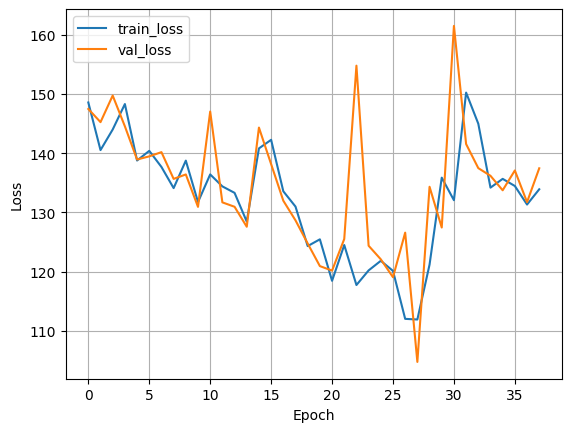

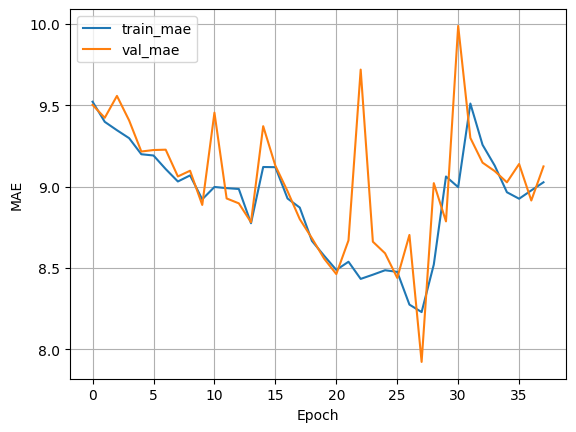

In [27]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_mae", "val_mae"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="MAE"
)

plt.show()



In [28]:
# Evaluación
trainer.test(model = rnn_model, datamodule = data_module, ckpt_path = 'best')

Restoring states from the checkpoint path at logs/rnn-proyecto-final/version_6/checkpoints/epoch=27-step=18424.ckpt
Loaded model weights from the checkpoint at logs/rnn-proyecto-final/version_6/checkpoints/epoch=27-step=18424.ckpt


Output()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    101.21678924560547     │
│         test_mae          │    7.8146491050720215     │
│         test_rmse         │     9.96672534942627      │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 101.21678924560547,
  'test_mae': 7.8146491050720215,
  'test_rmse': 9.96672534942627}]

In [29]:
# Inicialización del modulo lightning
lstm_model = StockLSTM(input_size=input_size, learning_rate= LEARNING_RATE)

callback_check = ModelCheckpoint(save_top_k=1, mode="min", monitor="val_rmse") # guardamos el mejor modelo monitoreado en la acc de validación. Por qué no la de entrenamiento?

callback_tqdm = RichProgressBar(leave=True)

early_stopping = EarlyStopping(monitor='val_rmse', patience=10, mode='min')

logger = CSVLogger(save_dir="logs/", name="lstm-proyecto-final")

In [30]:
trainer = pl.Trainer(max_epochs=NUM_EPOCHS,
                    callbacks=[early_stopping, callback_check, callback_tqdm],
                    accelerator="auto",  # Uses GPUs or TPUs if available
                    devices=1,  # Uses all available GPUs/TPUs if applicable
                    logger=logger,
                    deterministic=False,
                    log_every_n_steps=10)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [31]:
start_time = time.time()
trainer.fit(model = lstm_model, datamodule = data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

┏━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type    ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ lstm    │ LSTM    │  379 K │ train │
│ 1 │ fc      │ Linear  │    129 │ train │
│ 2 │ dropout │ Dropout │      0 │ train │
└───┴─────────┴─────────┴────────┴───────┘

Trainable params: 380 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 380 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 3                                                                                           
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Tiempo de entrenamiento en minutos: 19.97


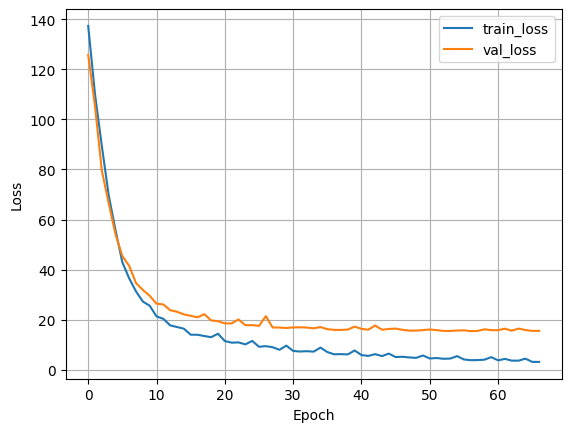

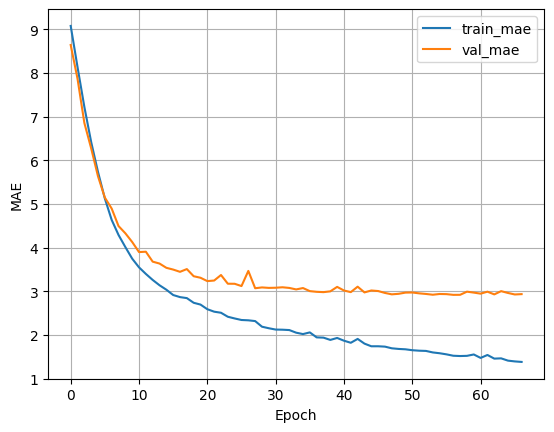

In [32]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_mae", "val_mae"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="MAE"
)

plt.show()

In [33]:
# Evaluación
trainer.test(model = lstm_model, datamodule = data_module, ckpt_path = 'best')

Restoring states from the checkpoint path at logs/lstm-proyecto-final/version_0/checkpoints/epoch=56-step=37506.ckpt
Loaded model weights from the checkpoint at logs/lstm-proyecto-final/version_0/checkpoints/epoch=56-step=37506.ckpt


Output()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     5.370441913604736     │
│         test_mae          │    1.6371750831604004     │
│         test_rmse         │    2.2970266342163086     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5.370441913604736,
  'test_mae': 1.6371750831604004,
  'test_rmse': 2.2970266342163086}]

In [34]:
# Inicialización del modulo lightning
gru_model = StockGRU(input_size=input_size, learning_rate= LEARNING_RATE)

callback_check = ModelCheckpoint(save_top_k=1, mode="min", monitor="val_rmse") # guardamos el mejor modelo monitoreado en la acc de validación. Por qué no la de entrenamiento?

callback_tqdm = RichProgressBar(leave=True)

early_stopping = EarlyStopping(monitor='val_rmse', patience=10, mode='min')

logger = CSVLogger(save_dir="logs/", name="gru-proyecto-final")

In [35]:
trainer = pl.Trainer(max_epochs=NUM_EPOCHS,
                    callbacks=[early_stopping, callback_check, callback_tqdm],
                    accelerator="auto",  # Uses GPUs or TPUs if available
                    devices=1,  # Uses all available GPUs/TPUs if applicable
                    logger=logger,
                    deterministic=False,
                    log_every_n_steps=10)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [36]:
start_time = time.time()
trainer.fit(model = gru_model, datamodule = data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

┏━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type    ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ gru     │ GRU     │  284 K │ train │
│ 1 │ fc      │ Linear  │    129 │ train │
│ 2 │ dropout │ Dropout │      0 │ train │
└───┴─────────┴─────────┴────────┴───────┘

Trainable params: 285 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 285 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 3                                                                                           
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Tiempo de entrenamiento en minutos: 74.55


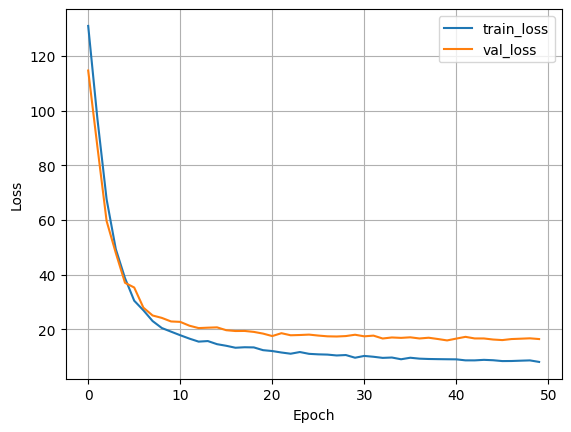

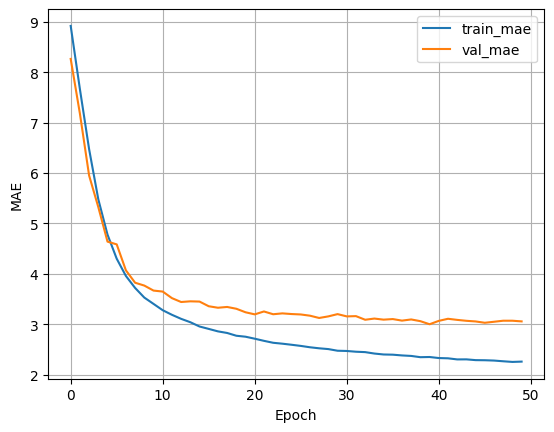

In [37]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_mae", "val_mae"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="MAE"
)

plt.show()

In [38]:
# Evaluación
trainer.test(model = gru_model, datamodule = data_module, ckpt_path = 'best')

Restoring states from the checkpoint path at logs/gru-proyecto-final/version_0/checkpoints/epoch=39-step=26320.ckpt
Loaded model weights from the checkpoint at logs/gru-proyecto-final/version_0/checkpoints/epoch=39-step=26320.ckpt


Output()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     8.359695434570312     │
│         test_mae          │     2.135964870452881     │
│         test_rmse         │       2.85400390625       │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 8.359695434570312,
  'test_mae': 2.135964870452881,
  'test_rmse': 2.85400390625}]

# **TFT**

In [49]:
# Inicialización del modulo lightning
tft_model = StockTFT(input_size=input_size, learning_rate= LEARNING_RATE)

callback_check = ModelCheckpoint(save_top_k=1, mode="min", monitor="val_rmse") # guardamos el mejor modelo monitoreado en la acc de validación. Por qué no la de entrenamiento?

callback_tqdm = RichProgressBar(leave=True)

early_stopping = EarlyStopping(monitor='val_rmse', patience=10, mode='min')

logger = CSVLogger(save_dir="logs/", name="tft-proyecto-final")

In [50]:
trainer = pl.Trainer(max_epochs=NUM_EPOCHS,
                    callbacks=[early_stopping, callback_check, callback_tqdm],
                    accelerator="auto",  # Uses GPUs or TPUs if available
                    devices=1,  # Uses all available GPUs/TPUs if applicable
                    logger=logger,
                    deterministic=False,
                    log_every_n_steps=10)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [51]:
start_time = time.time()
trainer.fit(model = tft_model, datamodule = data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

┏━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name               ┃ Type                            ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ temporal_vsn       │ VariableSelectionNetwork        │  248 K │ train │
│ 1 │ position_encoding  │ PositionalEncoding              │      0 │ train │
│ 2 │ lstm_encoder       │ LSTM                            │  2.1 M │ train │
│ 3 │ temporal_attention │ InterpretableMultiHeadAttention │  263 K │ train │
│ 4 │ grn_attention      │ GatedResidualNetwork            │  197 K │ train │
│ 5 │ grn_final          │ GatedResidualNetwork            │  197 K │ train │
│ 6 │ output_layer       │ Linear                          │    257 │ train │
│ 7 │ layer_norm_attn    │ LayerNorm                       │    512 │ train │
│ 8 │ layer_norm_final   │ LayerNorm                       │    512 │ train │
│ 9 │ dropout_layer      │ Dropout                         │      0 │ train │
└───┴────────────────────┴─────────────────────────────────┴────────┴───────┘

Trainable params: 3.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 45                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Tiempo de entrenamiento en minutos: 79.85


# MODELO 8 heads

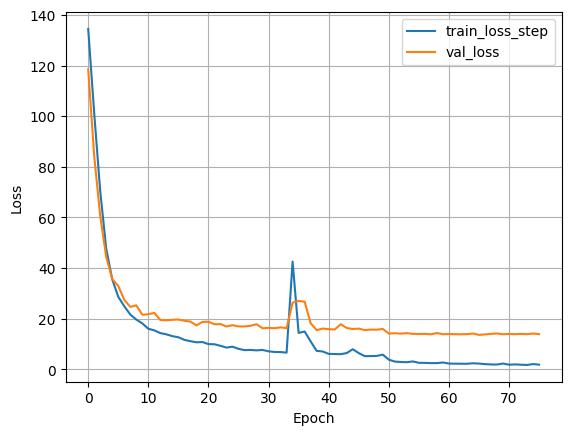

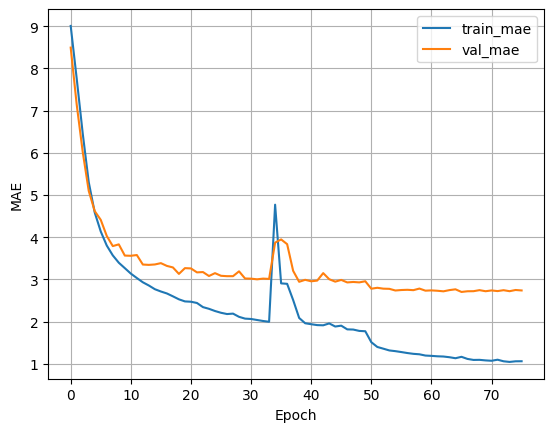

In [52]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss_step", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_mae", "val_mae"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="MAE"
)

plt.show()

# MODELO ANTERIOR N heads 4

In [ ]:
# metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

# aggreg_metrics = []
# agg_col = "epoch"
# for i, dfg in metrics.groupby(agg_col):
#     agg = dict(dfg.mean())
#     agg[agg_col] = i
#     aggreg_metrics.append(agg)

# df_metrics = pd.DataFrame(aggreg_metrics)
# df_metrics[["train_loss_step", "val_loss"]].plot(
#     grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
# )
# df_metrics[["train_mae", "val_mae"]].plot(
#     grid=True, legend=True, xlabel="Epoch", ylabel="MAE"
# )

# plt.show()

In [53]:
trainer.test(model = tft_model, datamodule = data_module, ckpt_path = 'best')

Restoring states from the checkpoint path at logs/tft-proyecto-final/version_2/checkpoints/epoch=65-step=43428.ckpt
Loaded model weights from the checkpoint at logs/tft-proyecto-final/version_2/checkpoints/epoch=65-step=43428.ckpt


Output()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     4.138426303863525     │
│         test_mae          │    1.3563748598098755     │
│         test_rmse         │    1.3563748598098755     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 4.138426303863525,
  'test_mae': 1.3563748598098755,
  'test_rmse': 1.3563748598098755}]

## Predicción

In [54]:
def get_predictions_with_actuals(model, dataloader):
    device = next(model.parameters()).device  # obtiene el dispositivo del modelo
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in dataloader:
            # Asegúrate de mover los tensores al mismo device
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            predictions.append(outputs.cpu())  # devuelves a CPU para concatenar
            actuals.append(targets.cpu())

    return torch.cat(predictions).numpy(), torch.cat(actuals).numpy()


In [ ]:
# # Para obtener también los valores reales y comparar
# def get_predictions_with_actuals(model, dataloader):
#     """
#     Obtiene predicciones y valores reales para evaluación
#     """
#     model.eval()
#     all_preds = []
#     all_targets = []

#     with torch.no_grad():
#         for batch in dataloader:
#             x, y = batch
#             x = x
#             y = y

#             preds = model(x)
#             all_preds.append(preds.cpu())
#             all_targets.append(y.cpu())

#     all_preds = torch.cat(all_preds).numpy().flatten()
#     all_targets = torch.cat(all_targets).numpy().flatten()

#     return all_preds, all_targets

## RNN EVALUACIÓN

In [ ]:
# import pytorch_lightning as pl

# # Ruta del checkpoint
# checkpoint_path = "./resultados/rnn/epoch=15-step=32400.ckpt"

# # Cargar el modelo con los pesos
# rnn_model = BaseRNN.load_from_checkpoint(checkpoint_path)

# rnn_model.eval()  # Modo evaluación


In [55]:
# Obtener el dataloader de test
test_dataloader = data_module.test_dataloader()


# Obtener predicciones y valores reales
predicted, actual = get_predictions_with_actuals(rnn_model, test_dataloader)

print(predicted)
print(actual)

# Calcular métricas de error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
epsilon = 1e-8
mape = np.mean(np.abs((actual - predicted) / (actual + epsilon))) * 100

print(f"MAE: {mae:.2f}%")
print(f"RMSE: {rmse:.2f}%")
print(f"MAPE: {mape:.2f}%")

[[-9.9398365]
 [ 6.170493 ]
 [-4.627903 ]
 ...
 [ 5.127332 ]
 [ 3.1568978]
 [-9.865428 ]]
[[-12.461051  ]
 [  4.3661914 ]
 [-11.773573  ]
 ...
 [ 23.389133  ]
 [ -1.4756823 ]
 [ -0.07450142]]
MAE: 7.69%
RMSE: 9.97%
MAPE: 359.12%


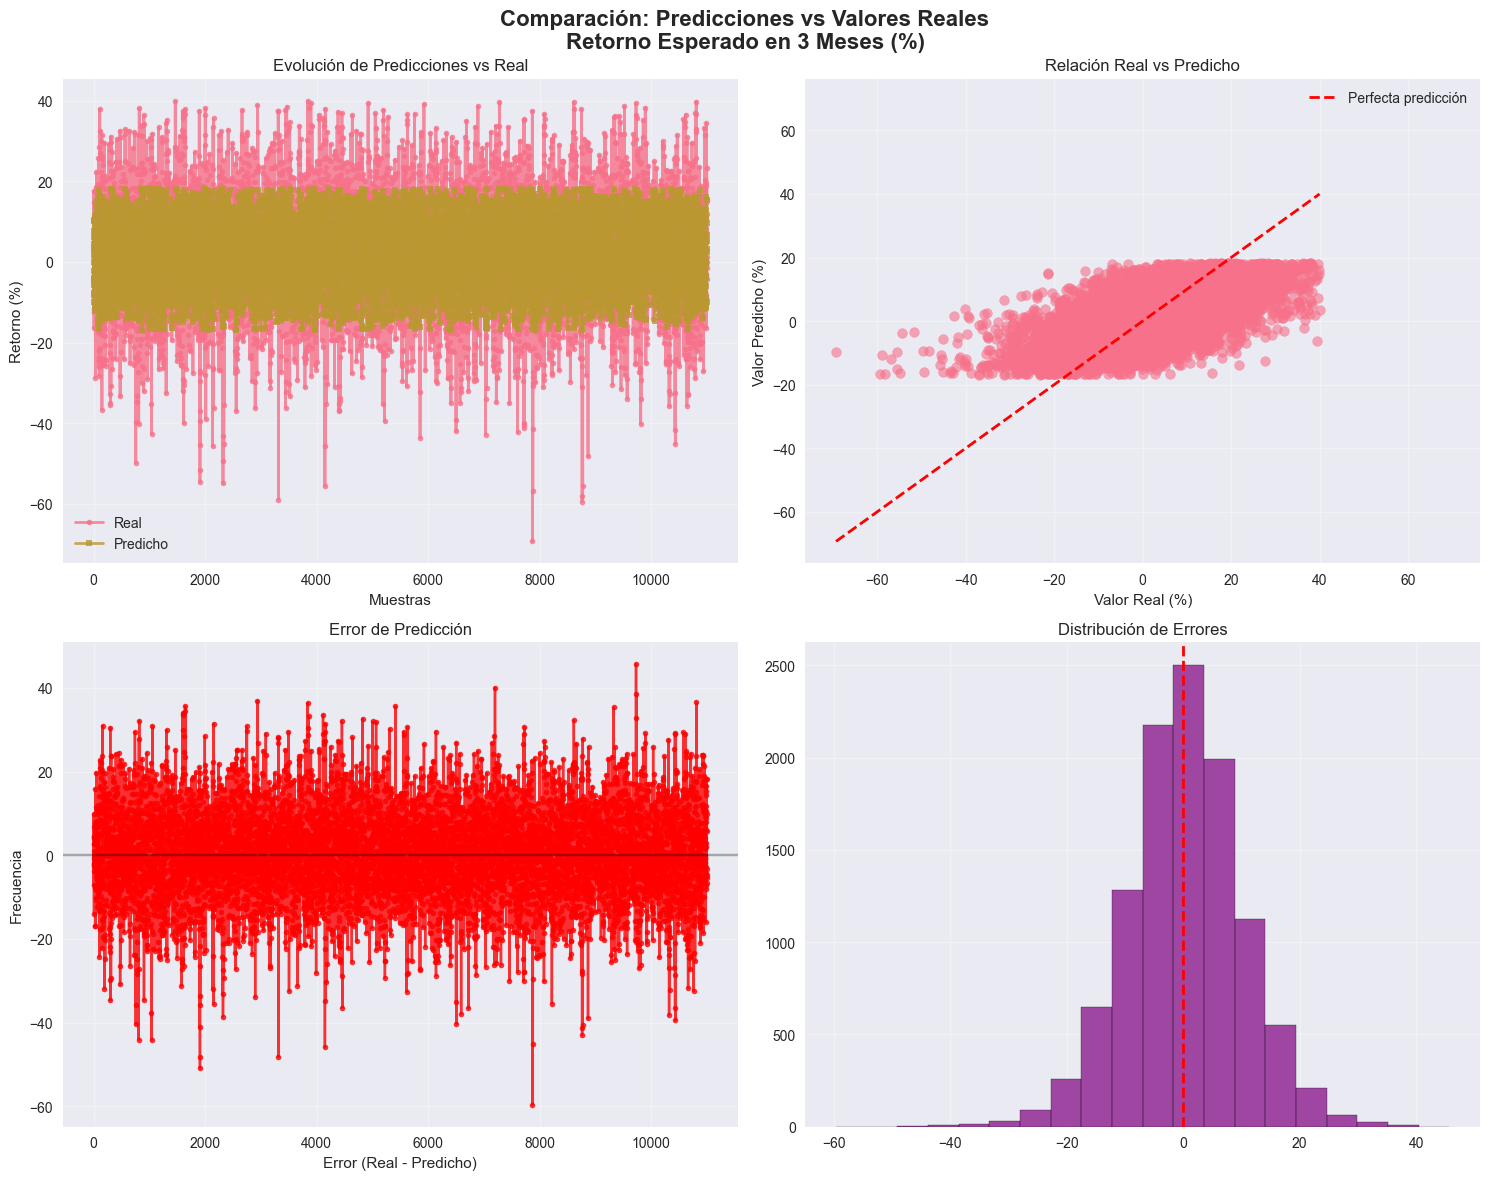

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Crear figura
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación: Predicciones vs Valores Reales\nRetorno Esperado en 3 Meses (%)',
             fontsize=16, fontweight='bold')

# 1. Gráfico de líneas comparativo
axes[0, 0].plot(actual, label='Real', marker='o', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].plot(predicted, label='Predicho', marker='s', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Muestras')
axes[0, 0].set_ylabel('Retorno (%)')
axes[0, 0].set_title('Evolución de Predicciones vs Real')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot con línea de perfecta predicción
max_val = max(max(predicted), max(actual))
min_val = min(min(predicted), min(actual))
limit = max(abs(max_val), abs(min_val)) * 1.1

axes[0, 1].scatter(actual, predicted, alpha=0.6, s=50)
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfecta predicción')
axes[0, 1].set_xlabel('Valor Real (%)')
axes[0, 1].set_ylabel('Valor Predicho (%)')
axes[0, 1].set_title('Relación Real vs Predicho')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(-limit, limit)
axes[0, 1].set_ylim(-limit, limit)

# 3. Gráfico de error (diferencia)
error = np.array(actual) - np.array(predicted)
axes[1, 0].plot(error, marker='o', markersize=4, color='red', alpha=0.8)
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].set_xlabel('Muestras')
axes[1, 0].set_ylabel('Error (Real - Predicho)')
axes[1, 0].set_title('Error de Predicción')
axes[1, 0].grid(True, alpha=0.3)

# 4. Histograma de errores
axes[1, 1].hist(error, bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Error (Real - Predicho)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Errores')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## LSTM EVALUACIÓN

In [ ]:
# import pytorch_lightning as pl

# # Ruta del checkpoint
# checkpoint_path = "./resultados/lstm/epoch=40-step=83025.ckpt"

# # Cargar el modelo con los pesos
# lstm_model = StockLSTM.load_from_checkpoint(checkpoint_path)

# lstm_model.eval()  # Modo evaluación

In [57]:
# Obtener el dataloader de test
test_dataloader = data_module.test_dataloader()

# Obtener predicciones y valores reales
predicted, actual = get_predictions_with_actuals(lstm_model, test_dataloader)

print(predicted)
print(actual)

# Calcular métricas de error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
epsilon = 1e-8
mape = np.mean(np.abs((actual - predicted) / (actual + epsilon))) * 100

print(f"MAE: {mae:.2f}%")
print(f"RMSE: {rmse:.2f}%")
print(f"MAPE: {mape:.2f}%")

[[-10.99391  ]
 [  4.4569235]
 [-13.339127 ]
 ...
 [ 23.280268 ]
 [ -3.641778 ]
 [  2.6829147]]
[[-12.461051  ]
 [  4.3661914 ]
 [-11.773573  ]
 ...
 [ 23.389133  ]
 [ -1.4756823 ]
 [ -0.07450142]]
MAE: 1.63%
RMSE: 2.31%
MAPE: 128.25%


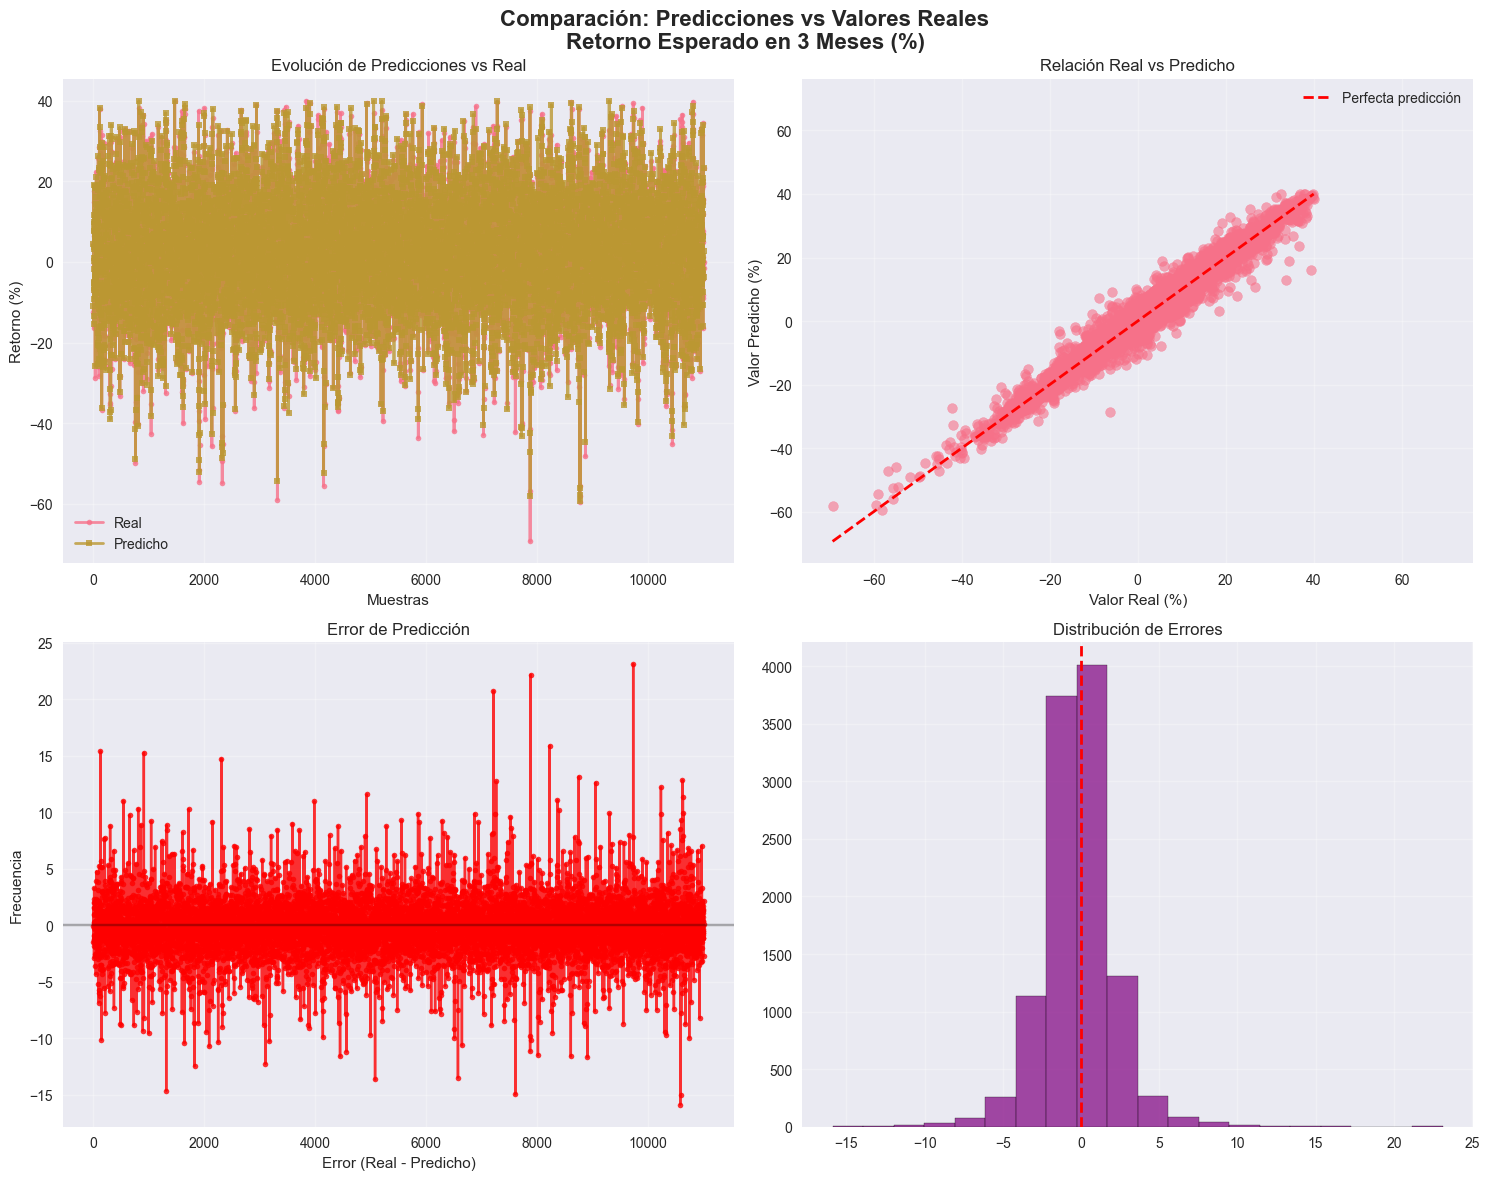

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Crear figura
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación: Predicciones vs Valores Reales\nRetorno Esperado en 3 Meses (%)',
             fontsize=16, fontweight='bold')

# 1. Gráfico de líneas comparativo
axes[0, 0].plot(actual, label='Real', marker='o', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].plot(predicted, label='Predicho', marker='s', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Muestras')
axes[0, 0].set_ylabel('Retorno (%)')
axes[0, 0].set_title('Evolución de Predicciones vs Real')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot con línea de perfecta predicción
max_val = max(max(predicted), max(actual))
min_val = min(min(predicted), min(actual))
limit = max(abs(max_val), abs(min_val)) * 1.1

axes[0, 1].scatter(actual, predicted, alpha=0.6, s=50)
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfecta predicción')
axes[0, 1].set_xlabel('Valor Real (%)')
axes[0, 1].set_ylabel('Valor Predicho (%)')
axes[0, 1].set_title('Relación Real vs Predicho')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(-limit, limit)
axes[0, 1].set_ylim(-limit, limit)

# 3. Gráfico de error (diferencia)
error = np.array(actual) - np.array(predicted)
axes[1, 0].plot(error, marker='o', markersize=4, color='red', alpha=0.8)
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].set_xlabel('Muestras')
axes[1, 0].set_ylabel('Error (Real - Predicho)')
axes[1, 0].set_title('Error de Predicción')
axes[1, 0].grid(True, alpha=0.3)

# 4. Histograma de errores
axes[1, 1].hist(error, bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Error (Real - Predicho)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Errores')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## GRU EVALUACIÓN

In [ ]:
# import pytorch_lightning as pl

# # Ruta del checkpoint
# checkpoint_path = "./resultados/gru/epoch=20-step=42525.ckpt"

# # Cargar el modelo con los pesos
# gru_model = StockGRU.load_from_checkpoint(checkpoint_path)

# gru_model.eval()  # Modo evaluación

In [59]:
# Obtener el dataloader de test
test_dataloader = data_module.test_dataloader()

# Obtener predicciones y valores reales
predicted, actual = get_predictions_with_actuals(gru_model, test_dataloader)

print(predicted)
print(actual)

# Calcular métricas de error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
epsilon = 1e-8
mape = np.mean(np.abs((actual - predicted) / (actual + epsilon))) * 100

print(f"MAE: {mae:.2f}%")
print(f"RMSE: {rmse:.2f}%")
print(f"MAPE: {mape:.2f}%")

[[ -9.128642 ]
 [  1.9758844]
 [-12.305949 ]
 ...
 [ 27.000715 ]
 [ -2.9067369]
 [  0.2105372]]
[[-12.461051  ]
 [  4.3661914 ]
 [-11.773573  ]
 ...
 [ 23.389133  ]
 [ -1.4756823 ]
 [ -0.07450142]]
MAE: 2.14%
RMSE: 2.89%
MAPE: 231.38%


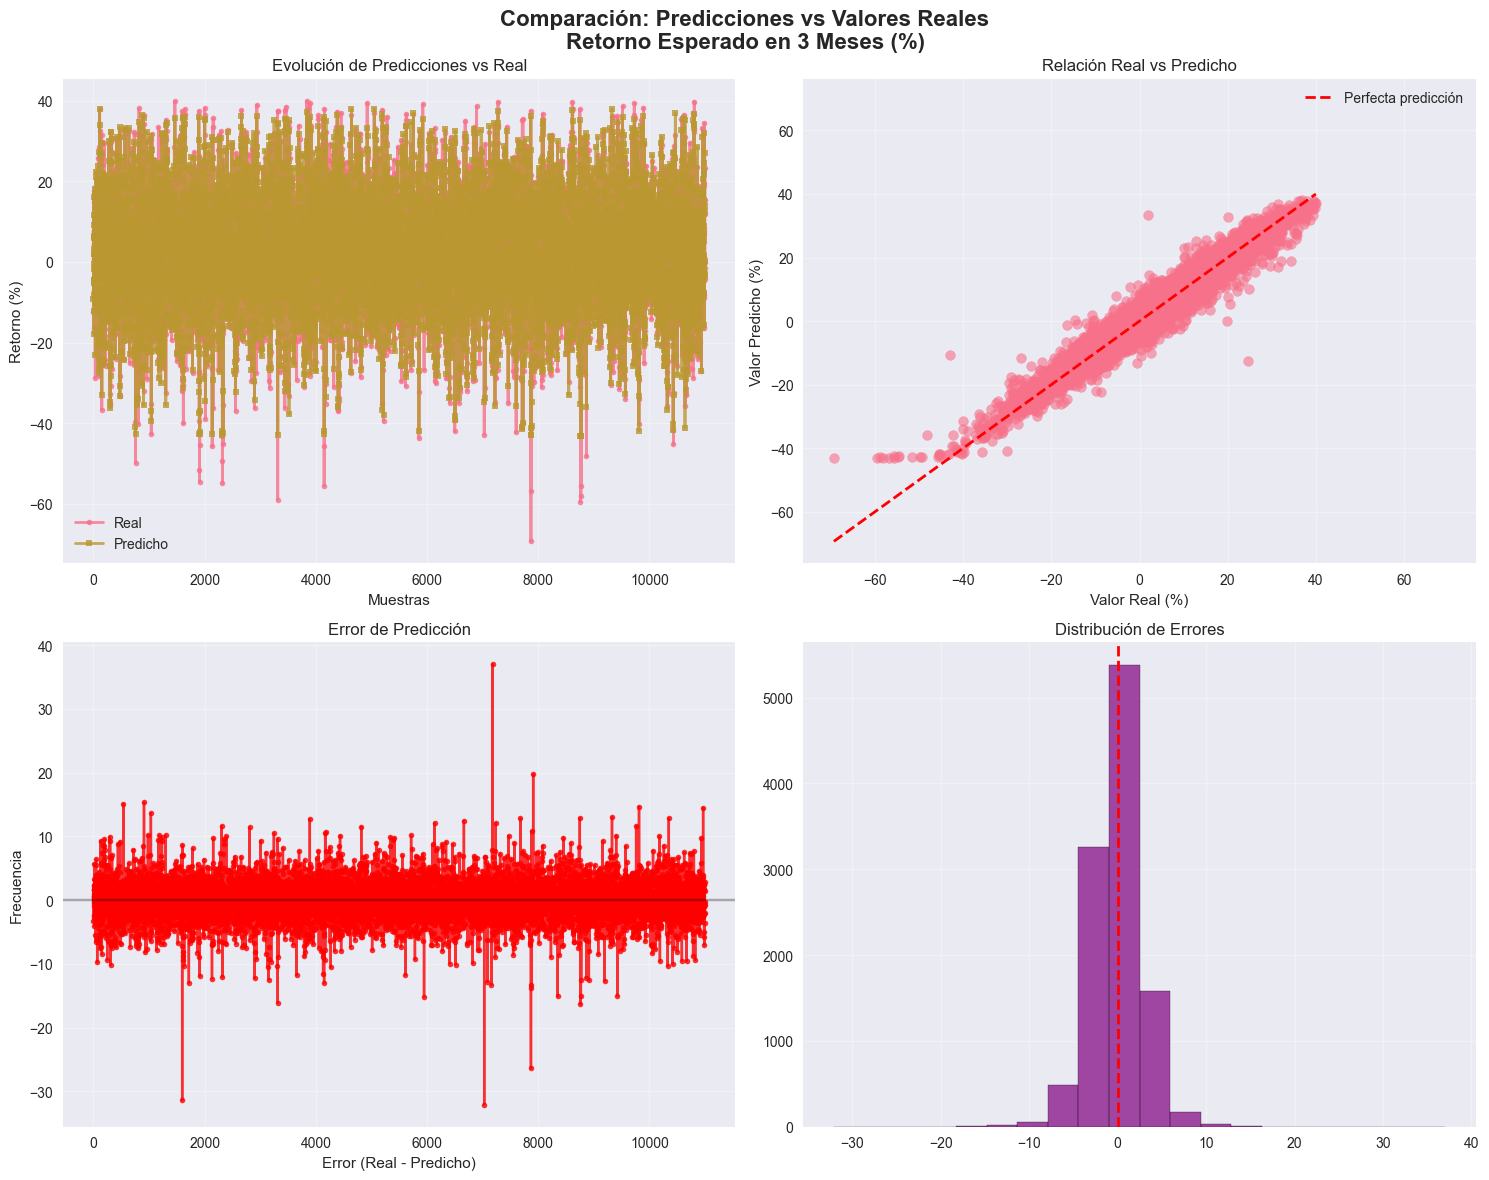

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Crear figura
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación: Predicciones vs Valores Reales\nRetorno Esperado en 3 Meses (%)',
             fontsize=16, fontweight='bold')

# 1. Gráfico de líneas comparativo
axes[0, 0].plot(actual, label='Real', marker='o', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].plot(predicted, label='Predicho', marker='s', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Muestras')
axes[0, 0].set_ylabel('Retorno (%)')
axes[0, 0].set_title('Evolución de Predicciones vs Real')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot con línea de perfecta predicción
max_val = max(max(predicted), max(actual))
min_val = min(min(predicted), min(actual))
limit = max(abs(max_val), abs(min_val)) * 1.1

axes[0, 1].scatter(actual, predicted, alpha=0.6, s=50)
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfecta predicción')
axes[0, 1].set_xlabel('Valor Real (%)')
axes[0, 1].set_ylabel('Valor Predicho (%)')
axes[0, 1].set_title('Relación Real vs Predicho')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(-limit, limit)
axes[0, 1].set_ylim(-limit, limit)

# 3. Gráfico de error (diferencia)
error = np.array(actual) - np.array(predicted)
axes[1, 0].plot(error, marker='o', markersize=4, color='red', alpha=0.8)
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].set_xlabel('Muestras')
axes[1, 0].set_ylabel('Error (Real - Predicho)')
axes[1, 0].set_title('Error de Predicción')
axes[1, 0].grid(True, alpha=0.3)

# 4. Histograma de errores
axes[1, 1].hist(error, bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Error (Real - Predicho)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Errores')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## TFT EVALUACIÓN

In [ ]:
# import pytorch_lightning as pl

# # Ruta del checkpoint
# checkpoint_path = "./resultados/tff/epoch=6-step=14175.ckpt"

# # Cargar el modelo con los pesos
# tft_model = StockTFT.load_from_checkpoint(checkpoint_path)

# rnn_model.eval()  # Modo evaluación

In [61]:
# Obtener el dataloader de test
test_dataloader = data_module.test_dataloader()

# Obtener predicciones y valores reales
predicted, actual = get_predictions_with_actuals(tft_model, test_dataloader)

print(predicted)
print(actual)

# Calcular métricas de error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
epsilon = 1e-8
mape = np.mean(np.abs((actual - predicted) / (actual + epsilon))) * 100

print(f"MAE: {mae:.2f}%")
print(f"RMSE: {rmse:.2f}%")
print(f"MAPE: {mape:.2f}%")

[[-13.386688 ]
 [  2.8747065]
 [-11.470298 ]
 ...
 [ 23.578321 ]
 [ -3.4353456]
 [ -1.8272594]]
[[-12.461051  ]
 [  4.3661914 ]
 [-11.773573  ]
 ...
 [ 23.389133  ]
 [ -1.4756823 ]
 [ -0.07450142]]
MAE: 1.36%
RMSE: 2.03%
MAPE: 201.05%


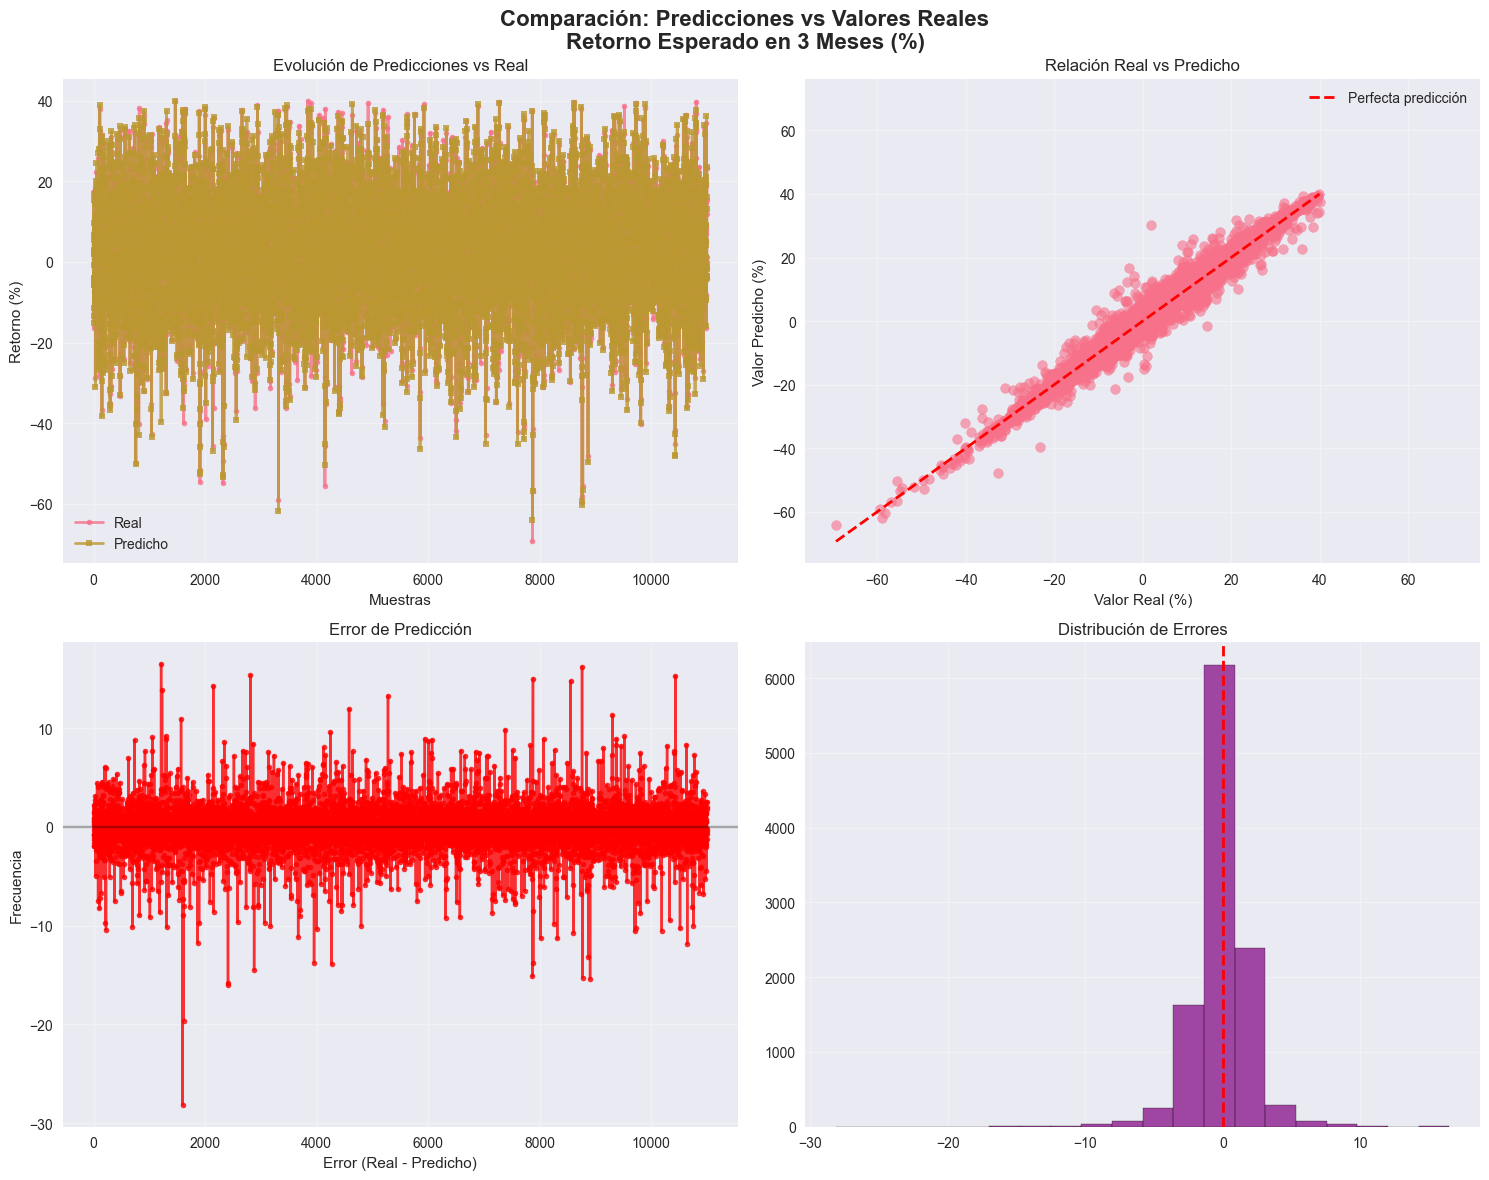

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Crear figura
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación: Predicciones vs Valores Reales\nRetorno Esperado en 3 Meses (%)',
             fontsize=16, fontweight='bold')

# 1. Gráfico de líneas comparativo
axes[0, 0].plot(actual, label='Real', marker='o', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].plot(predicted, label='Predicho', marker='s', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Muestras')
axes[0, 0].set_ylabel('Retorno (%)')
axes[0, 0].set_title('Evolución de Predicciones vs Real')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot con línea de perfecta predicción
max_val = max(max(predicted), max(actual))
min_val = min(min(predicted), min(actual))
limit = max(abs(max_val), abs(min_val)) * 1.1

axes[0, 1].scatter(actual, predicted, alpha=0.6, s=50)
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfecta predicción')
axes[0, 1].set_xlabel('Valor Real (%)')
axes[0, 1].set_ylabel('Valor Predicho (%)')
axes[0, 1].set_title('Relación Real vs Predicho')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(-limit, limit)
axes[0, 1].set_ylim(-limit, limit)

# 3. Gráfico de error (diferencia)
error = np.array(actual) - np.array(predicted)
axes[1, 0].plot(error, marker='o', markersize=4, color='red', alpha=0.8)
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].set_xlabel('Muestras')
axes[1, 0].set_ylabel('Error (Real - Predicho)')
axes[1, 0].set_title('Error de Predicción')
axes[1, 0].grid(True, alpha=0.3)

# 4. Histograma de errores
axes[1, 1].hist(error, bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Error (Real - Predicho)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Errores')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## COMPROBACIÓN MODULO

In [63]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def get_first_sequence_for_prediction(df, lookback=60):
    """
    Obtiene la primera secuencia válida para predicción

    Args:
        ticker_file: Ruta al archivo CSV del ticker
        lookback: Número de días históricos para la secuencia

    Returns:
        Primera secuencia escalada y datos originales
    """
    # Cargar datos
    # df = pd.read_csv(ticker_file)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    # Determinar columnas de features
    feature_columns = df.drop(['Date', 'Target_Direction', 'Target_3M_Return'],
                            axis=1, errors='ignore').columns.tolist()

    print(f"Usando {len(feature_columns)} features: {feature_columns}")

    # Extraer features
    features = df[feature_columns].values

    # Escalar features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Obtener la PRIMERA secuencia completa (cambió aquí)
    first_sequence = features_scaled[:lookback]  # Primeros 'lookback' elementos

    # Verificar que no hay NaN
    if np.any(np.isnan(first_sequence)):
        print("Advertencia: La secuencia contiene valores NaN")
        first_sequence = np.nan_to_num(first_sequence)

    # Información adicional (ahora de la primera secuencia)
    first_date = df['Date'].iloc[lookback - 1]  # Fecha del último elemento de la primera secuencia
    first_close = df['Close'].iloc[lookback - 1] if 'Close' in df.columns else None
    start_date = df['Date'].iloc[0]  # Fecha de inicio de la secuencia

    return {
        'sequence': first_sequence,
        'first_date': first_date,        # Fecha del último elemento de la secuencia
        'start_date': start_date,        # Fecha del primer elemento de la secuencia
        'first_close': first_close,
        'feature_names': feature_columns,
        'scaler': scaler,
        'original_data': df
    }

# Ejemplo de uso
ticker_file = './data_final_v3/GOOGL_completo_arreglado.csv'
lookback=60
df = pd.read_csv(ticker_file)

google_data = get_first_sequence_for_prediction(df=df, lookback=lookback)
print(f"Fecha de inicio de secuencia: {google_data['start_date']}")
print(f"Fecha del último elemento de la secuencia: {google_data['first_date']}")
print(f"Precio de cierre en esa fecha: {google_data['first_close']}")
print(f"Shape de la secuencia: {google_data['sequence'].shape}")
print(f"Valor real {df.iloc[lookback - 1]['Target_3M_Return']}")

Usando 96 features: ['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'RSI', 'STOCH_K', 'STOCH_D', 'MACD', 'MACD_Signal', 'MACD_Hist', 'ADX', 'CCI', 'WILLR', 'ULTOSC', 'ROC', 'ATR', 'NATR', 'TRANGE', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'MOM', 'PPO', 'APO', 'AROON_Up', 'AROON_Down', 'AROONOSC', 'BOP', 'Price_Change', 'High_Low_Ratio', 'Close_Open_Ratio', 'ROE', 'ROA', 'Debt_to_Equity', 'Profit_Margin', 'Operating_Margin', 'Asset_Turnover', 'Financial_Leverage', 'EPS_Calc', 'Free_Cash_Flow', 'Operating_Cash_Flow', 'Investing_Cash_Flow', 'Financing_Cash_Flow', 'Beginning_Cash_Position', 'End_Cash_Position', 'Changes_In_Cash', 'Cash_And_Cash_Equivalents', 'Net_Income', 'Pretax_Income', 'Total_Revenue', 'Operating_Revenue', 'Normalized_Income', 'Net_Income_Common_Stockholders', 'Net_Income_From_Continuing_Operations', 'Net_Income_From_Continuing_And_Discontinued_Operation', 'Net_Income_Including_Noncontrolling_Interests', 'Net_Income_Continuous_Operations', 'Di

In [65]:
def predict_future_return(model, sequence_data, device=None):
    """
    Predice el retorno futuro usando el modelo GRU

    Args:
        model: Modelo GRU entrenado
        sequence_data: Datos de la secuencia obtenidos con get_last_sequence_for_prediction
        device: Dispositivo (cuda/cpu)

    Returns:
        Predicción del retorno porcentual
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()
    model.to(device)

    # Preparar la secuencia para el modelo
    sequence = sequence_data['sequence']
    sequence_tensor = torch.FloatTensor(sequence).unsqueeze(0)  # Add batch dimension
    sequence_tensor = sequence_tensor.to(device)

    # Hacer predicción
    with torch.no_grad():
        prediction = model(sequence_tensor)
        predicted_return = prediction.item()

    return predicted_return

# Ejemplo de uso
predicted_return_rnn = predict_future_return(rnn_model, google_data)
print(f"Predicción RNN de retorno: {predicted_return_rnn:.2f}%")


# Ejemplo de uso
predicted_return_lstm = predict_future_return(lstm_model, google_data)
print(f"Predicción LSTM de retorno: {predicted_return_lstm:.2f}%")

# Ejemplo de uso
predicted_return_gru = predict_future_return(gru_model, google_data)
print(f"Predicción GRU de retorno: {predicted_return_gru:.2f}%")

# Ejemplo de uso
predicted_return_tft = predict_future_return(tft_model, google_data)
print(f"Predicción TFT de retorno: {predicted_return_tft:.2f}%")


predicted_return_average = predicted_return_lstm * 0.4 + predicted_return_gru * 0.2 + predicted_return_tft * 0.4
print(f"Predicción promedio de retorno: {predicted_return_average:.2f}%")


Predicción RNN de retorno: -8.99%
Predicción LSTM de retorno: -13.07%
Predicción GRU de retorno: -10.75%
Predicción TFT de retorno: -23.88%
Predicción promedio de retorno: -16.93%


## PREDICIENDO EL FUTURO

### ACCION GOOGLE

In [67]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def get_last_sequence_for_prediction(ticker_file, lookback=60):
    """
    Obtiene la última secuencia válida para predicción

    Args:
        ticker_file: Ruta al archivo CSV del ticker
        lookback: Número de días históricos para la secuencia
        feature_columns: Columnas a usar como features (si None, usa todas excepto Date y targets)

    Returns:
        Última secuencia escalada y datos originales
    """
    # Cargar datos
    df = pd.read_csv(ticker_file)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    # Determinar columnas de features
    # if feature_columns is None:
    feature_columns = df.drop(['Date', 'Target_Direction', 'Target_3M_Return'],
                            axis=1, errors='ignore').columns.tolist()

    print(f"Usando {len(feature_columns)} features: {feature_columns}")

    # Extraer features
    features = df[feature_columns].values

    # Escalar features (usando los mismos parámetros que en entrenamiento)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Obtener la última secuencia completa
    last_sequence = features_scaled[-lookback:]

    # Verificar que no hay NaN
    if np.any(np.isnan(last_sequence)):
        print("Advertencia: La secuencia contiene valores NaN")
        last_sequence = np.nan_to_num(last_sequence)

    # Información adicional
    last_date = df['Date'].iloc[-1]
    last_close = df['Close'].iloc[-1] if 'Close' in df.columns else None

    return {
        'sequence': last_sequence,
        'last_date': last_date,
        'last_close': last_close,
        'feature_names': feature_columns,
        'scaler': scaler,
        'original_data': df
    }

# Ejemplo de uso
googl_data = get_last_sequence_for_prediction('./data_final_unknow_values_v3/GOOGL_completo_arreglado.csv', lookback=60)
print(f"Última fecha disponible: {googl_data['last_date']}")
print(f"Último precio de cierre: {googl_data['last_close']}")
print(f"Shape de la secuencia: {googl_data['sequence'].shape}")

Usando 96 features: ['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'RSI', 'STOCH_K', 'STOCH_D', 'MACD', 'MACD_Signal', 'MACD_Hist', 'ADX', 'CCI', 'WILLR', 'ULTOSC', 'ROC', 'ATR', 'NATR', 'TRANGE', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'MOM', 'PPO', 'APO', 'AROON_Up', 'AROON_Down', 'AROONOSC', 'BOP', 'Price_Change', 'High_Low_Ratio', 'Close_Open_Ratio', 'ROE', 'ROA', 'Debt_to_Equity', 'Profit_Margin', 'Operating_Margin', 'Asset_Turnover', 'Financial_Leverage', 'EPS_Calc', 'Free_Cash_Flow', 'Operating_Cash_Flow', 'Investing_Cash_Flow', 'Financing_Cash_Flow', 'Beginning_Cash_Position', 'End_Cash_Position', 'Changes_In_Cash', 'Cash_And_Cash_Equivalents', 'Net_Income', 'Pretax_Income', 'Total_Revenue', 'Operating_Revenue', 'Normalized_Income', 'Net_Income_Common_Stockholders', 'Net_Income_From_Continuing_Operations', 'Net_Income_From_Continuing_And_Discontinued_Operation', 'Net_Income_Including_Noncontrolling_Interests', 'Net_Income_Continuous_Operations', 'Di

In [68]:
# Ejemplo de uso
predicted_return_rnn = predict_future_return(rnn_model, googl_data)
print(f"Predicción RNN de retorno: {predicted_return_rnn:.2f}%")


# Ejemplo de uso
predicted_return_lstm = predict_future_return(lstm_model, googl_data)
print(f"Predicción LSTM de retorno: {predicted_return_lstm:.2f}%")

# Ejemplo de uso
predicted_return_gru = predict_future_return(gru_model, googl_data)
print(f"Predicción GRU de retorno: {predicted_return_gru:.2f}%")

# Ejemplo de uso
predicted_return_tft = predict_future_return(tft_model, googl_data)
print(f"Predicción TFT de retorno: {predicted_return_tft:.2f}%")


predicted_return_average = predicted_return_lstm * 0.4 + predicted_return_gru * 0.2 + predicted_return_tft * 0.4
print(f"Predicción promedio de retorno: {predicted_return_average:.2f}%")

Predicción RNN de retorno: -8.27%
Predicción LSTM de retorno: -4.91%
Predicción GRU de retorno: -8.44%
Predicción TFT de retorno: -18.47%
Predicción promedio de retorno: -11.04%


```bash
DATA REAL:
Date,Open,High,Low,Close,Volume
2025-07-09,175.25,179.44000244140625,172.77000427246094,176.6199951171875,43025600
```

In [69]:
precio_2025_07_21 = 166.77000427246094
precio_2025_09_18 =  252.02999877929688

retorno_real = (precio_2025_09_18 - precio_2025_07_21) / precio_2025_07_21
print(retorno_real*100)

51.12429832857844


### ACCION APPLE

In [70]:
# Ejemplo de uso
apple_data = get_last_sequence_for_prediction('./data_final_unknow_values_v3/AAPL_completo_arreglado.csv', lookback=60)
print(f"Última fecha disponible: {apple_data['last_date']}")
print(f"Último precio de cierre: {apple_data['last_close']}")
print(f"Shape de la secuencia: {apple_data['sequence'].shape}")

Usando 96 features: ['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'RSI', 'STOCH_K', 'STOCH_D', 'MACD', 'MACD_Signal', 'MACD_Hist', 'ADX', 'CCI', 'WILLR', 'ULTOSC', 'ROC', 'ATR', 'NATR', 'TRANGE', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'MOM', 'PPO', 'APO', 'AROON_Up', 'AROON_Down', 'AROONOSC', 'BOP', 'Price_Change', 'High_Low_Ratio', 'Close_Open_Ratio', 'ROE', 'ROA', 'Debt_to_Equity', 'Profit_Margin', 'Operating_Margin', 'Asset_Turnover', 'Financial_Leverage', 'EPS_Calc', 'Free_Cash_Flow', 'Operating_Cash_Flow', 'Investing_Cash_Flow', 'Financing_Cash_Flow', 'Beginning_Cash_Position', 'End_Cash_Position', 'Changes_In_Cash', 'Cash_And_Cash_Equivalents', 'Net_Income', 'Pretax_Income', 'Total_Revenue', 'Operating_Revenue', 'Normalized_Income', 'Net_Income_Common_Stockholders', 'Net_Income_From_Continuing_Operations', 'Net_Income_From_Continuing_And_Discontinued_Operation', 'Net_Income_Including_Noncontrolling_Interests', 'Net_Income_Continuous_Operations', 'Di

In [71]:
# Ejemplo de uso
predicted_return_rnn = predict_future_return(rnn_model, apple_data)
print(f"Predicción RNN de retorno: {predicted_return_rnn:.2f}%")


# Ejemplo de uso
predicted_return_lstm = predict_future_return(lstm_model, apple_data)
print(f"Predicción LSTM de retorno: {predicted_return_lstm:.2f}%")

# Ejemplo de uso
predicted_return_gru = predict_future_return(gru_model, apple_data)
print(f"Predicción GRU de retorno: {predicted_return_gru:.2f}%")

# Ejemplo de uso
predicted_return_tft = predict_future_return(tft_model, apple_data)
print(f"Predicción TFT de retorno: {predicted_return_tft:.2f}%")


predicted_return_average = predicted_return_lstm * 0.4 + predicted_return_gru * 0.2 + predicted_return_tft * 0.4
print(f"Predicción promedio de retorno: {predicted_return_average:.2f}%")

Predicción RNN de retorno: 11.31%
Predicción LSTM de retorno: -9.44%
Predicción GRU de retorno: -16.70%
Predicción TFT de retorno: 9.86%
Predicción promedio de retorno: -3.17%


In [72]:
precio_2025_07_21 = 212.4799
precio_2025_09_18 =  239.9700012

retorno_real = (precio_2025_09_18 - precio_2025_07_21) / precio_2025_07_21
print(retorno_real*100)

12.937741969946348


# ACCION IRM Real State

In [73]:
# Ejemplo de uso
irm_data = get_last_sequence_for_prediction('./data_final_unknow_values_v3/IRM_completo_arreglado.csv', lookback=60)
print(f"Última fecha disponible: {irm_data['last_date']}")
print(f"Último precio de cierre: {irm_data['last_close']}")
print(f"Shape de la secuencia: {irm_data['sequence'].shape}")

Usando 96 features: ['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'RSI', 'STOCH_K', 'STOCH_D', 'MACD', 'MACD_Signal', 'MACD_Hist', 'ADX', 'CCI', 'WILLR', 'ULTOSC', 'ROC', 'ATR', 'NATR', 'TRANGE', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'MOM', 'PPO', 'APO', 'AROON_Up', 'AROON_Down', 'AROONOSC', 'BOP', 'Price_Change', 'High_Low_Ratio', 'Close_Open_Ratio', 'ROE', 'ROA', 'Debt_to_Equity', 'Profit_Margin', 'Operating_Margin', 'Asset_Turnover', 'Financial_Leverage', 'EPS_Calc', 'Free_Cash_Flow', 'Operating_Cash_Flow', 'Investing_Cash_Flow', 'Financing_Cash_Flow', 'Beginning_Cash_Position', 'End_Cash_Position', 'Changes_In_Cash', 'Cash_And_Cash_Equivalents', 'Net_Income', 'Pretax_Income', 'Total_Revenue', 'Operating_Revenue', 'Normalized_Income', 'Net_Income_Common_Stockholders', 'Net_Income_From_Continuing_Operations', 'Net_Income_From_Continuing_And_Discontinued_Operation', 'Net_Income_Including_Noncontrolling_Interests', 'Net_Income_Continuous_Operations', 'Di

In [74]:
# Ejemplo de uso
predicted_return_rnn = predict_future_return(rnn_model, irm_data)
print(f"Predicción RNN de retorno: {predicted_return_rnn:.2f}%")


# Ejemplo de uso
predicted_return_lstm = predict_future_return(lstm_model, irm_data)
print(f"Predicción LSTM de retorno: {predicted_return_lstm:.2f}%")

# Ejemplo de uso
predicted_return_gru = predict_future_return(gru_model, irm_data)
print(f"Predicción GRU de retorno: {predicted_return_gru:.2f}%")

# Ejemplo de uso
predicted_return_tft = predict_future_return(tft_model, irm_data)
print(f"Predicción TFT de retorno: {predicted_return_tft:.2f}%")


predicted_return_average = predicted_return_lstm * 0.4 + predicted_return_gru * 0.2 + predicted_return_tft * 0.4
print(f"Predicción promedio de retorno: {predicted_return_average:.2f}%")

Predicción RNN de retorno: -2.94%
Predicción LSTM de retorno: 0.78%
Predicción GRU de retorno: -3.07%
Predicción TFT de retorno: -8.65%
Predicción promedio de retorno: -3.76%


In [75]:
precio_2025_07_21 = 98.7300033569336
precio_2025_09_18 =  98.91999816894531

retorno_real = (precio_2025_09_18 - precio_2025_07_21) / precio_2025_07_21
print(retorno_real*100)

0.19243877803269194


# Walmart CONSUMO MASIVO

In [76]:
# Ejemplo de uso
wmt_data = get_last_sequence_for_prediction('./data_final_unknow_values_v3/WMT_completo_arreglado.csv', lookback=60)
print(f"Última fecha disponible: {wmt_data['last_date']}")
print(f"Último precio de cierre: {wmt_data['last_close']}")
print(f"Shape de la secuencia: {wmt_data['sequence'].shape}")

Usando 96 features: ['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'RSI', 'STOCH_K', 'STOCH_D', 'MACD', 'MACD_Signal', 'MACD_Hist', 'ADX', 'CCI', 'WILLR', 'ULTOSC', 'ROC', 'ATR', 'NATR', 'TRANGE', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'MOM', 'PPO', 'APO', 'AROON_Up', 'AROON_Down', 'AROONOSC', 'BOP', 'Price_Change', 'High_Low_Ratio', 'Close_Open_Ratio', 'ROE', 'ROA', 'Debt_to_Equity', 'Profit_Margin', 'Operating_Margin', 'Asset_Turnover', 'Financial_Leverage', 'EPS_Calc', 'Free_Cash_Flow', 'Operating_Cash_Flow', 'Investing_Cash_Flow', 'Financing_Cash_Flow', 'Beginning_Cash_Position', 'End_Cash_Position', 'Changes_In_Cash', 'Cash_And_Cash_Equivalents', 'Net_Income', 'Pretax_Income', 'Total_Revenue', 'Operating_Revenue', 'Normalized_Income', 'Net_Income_Common_Stockholders', 'Net_Income_From_Continuing_Operations', 'Net_Income_From_Continuing_And_Discontinued_Operation', 'Net_Income_Including_Noncontrolling_Interests', 'Net_Income_Continuous_Operations', 'Di

In [77]:
# Ejemplo de uso
predicted_return_rnn = predict_future_return(rnn_model, wmt_data)
print(f"Predicción RNN de retorno: {predicted_return_rnn:.2f}%")


# Ejemplo de uso
predicted_return_lstm = predict_future_return(lstm_model, wmt_data)
print(f"Predicción LSTM de retorno: {predicted_return_lstm:.2f}%")

# Ejemplo de uso
predicted_return_gru = predict_future_return(gru_model, wmt_data)
print(f"Predicción GRU de retorno: {predicted_return_gru:.2f}%")

# Ejemplo de uso
predicted_return_tft = predict_future_return(tft_model, wmt_data)
print(f"Predicción TFT de retorno: {predicted_return_tft:.2f}%")


predicted_return_average = predicted_return_lstm * 0.4 + predicted_return_gru * 0.2 + predicted_return_tft * 0.4
print(f"Predicción promedio de retorno: {predicted_return_average:.2f}%")

Predicción RNN de retorno: -8.33%
Predicción LSTM de retorno: 3.57%
Predicción GRU de retorno: -5.82%
Predicción TFT de retorno: 2.68%
Predicción promedio de retorno: 1.34%


In [78]:
precio_2025_07_21 = 95.66999816894533
precio_2025_09_18 =  103.5999984741211

retorno_real = (precio_2025_09_18 - precio_2025_07_21) / precio_2025_07_21
print(retorno_real*100)

8.288910271715528


# SALUD  Johnson & Johnson

In [79]:
# Ejemplo de uso
jnj_data = get_last_sequence_for_prediction('./data_final_unknow_values_v3/JNJ_completo_arreglado.csv', lookback=60)
print(f"Última fecha disponible: {jnj_data['last_date']}")
print(f"Último precio de cierre: {jnj_data['last_close']}")
print(f"Shape de la secuencia: {jnj_data['sequence'].shape}")

Usando 96 features: ['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'RSI', 'STOCH_K', 'STOCH_D', 'MACD', 'MACD_Signal', 'MACD_Hist', 'ADX', 'CCI', 'WILLR', 'ULTOSC', 'ROC', 'ATR', 'NATR', 'TRANGE', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'MOM', 'PPO', 'APO', 'AROON_Up', 'AROON_Down', 'AROONOSC', 'BOP', 'Price_Change', 'High_Low_Ratio', 'Close_Open_Ratio', 'ROE', 'ROA', 'Debt_to_Equity', 'Profit_Margin', 'Operating_Margin', 'Asset_Turnover', 'Financial_Leverage', 'EPS_Calc', 'Free_Cash_Flow', 'Operating_Cash_Flow', 'Investing_Cash_Flow', 'Financing_Cash_Flow', 'Beginning_Cash_Position', 'End_Cash_Position', 'Changes_In_Cash', 'Cash_And_Cash_Equivalents', 'Net_Income', 'Pretax_Income', 'Total_Revenue', 'Operating_Revenue', 'Normalized_Income', 'Net_Income_Common_Stockholders', 'Net_Income_From_Continuing_Operations', 'Net_Income_From_Continuing_And_Discontinued_Operation', 'Net_Income_Including_Noncontrolling_Interests', 'Net_Income_Continuous_Operations', 'Di

In [80]:
# Ejemplo de uso
predicted_return_rnn = predict_future_return(rnn_model, jnj_data)
print(f"Predicción RNN de retorno: {predicted_return_rnn:.2f}%")


# Ejemplo de uso
predicted_return_lstm = predict_future_return(lstm_model, jnj_data)
print(f"Predicción LSTM de retorno: {predicted_return_lstm:.2f}%")

# Ejemplo de uso
predicted_return_gru = predict_future_return(gru_model, jnj_data)
print(f"Predicción GRU de retorno: {predicted_return_gru:.2f}%")

# Ejemplo de uso
predicted_return_tft = predict_future_return(tft_model, jnj_data)
print(f"Predicción TFT de retorno: {predicted_return_tft:.2f}%")


predicted_return_average = predicted_return_lstm * 0.4 + predicted_return_gru * 0.2 + predicted_return_tft * 0.4
print(f"Predicción promedio de retorno: {predicted_return_average:.2f}%")

Predicción RNN de retorno: 1.32%
Predicción LSTM de retorno: -5.08%
Predicción GRU de retorno: -0.77%
Predicción TFT de retorno: -6.31%
Predicción promedio de retorno: -4.71%


In [81]:
precio_2025_07_21 = 164.36000061035156
precio_2025_09_18 =  174.16000366210938

retorno_real = (precio_2025_09_18 - precio_2025_07_21) / precio_2025_07_21
print(retorno_real*100)



5.962523129329192


# Petroleo Chevron

In [82]:
# Ejemplo de uso

cvx_data = get_last_sequence_for_prediction('./data_final_unknow_values_v3/CVX_completo_arreglado.csv', lookback=60)
print(f"Última fecha disponible: {cvx_data['last_date']}")
print(f"Último precio de cierre: {cvx_data['last_close']}")
print(f"Shape de la secuencia: {cvx_data['sequence'].shape}")

Usando 96 features: ['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'RSI', 'STOCH_K', 'STOCH_D', 'MACD', 'MACD_Signal', 'MACD_Hist', 'ADX', 'CCI', 'WILLR', 'ULTOSC', 'ROC', 'ATR', 'NATR', 'TRANGE', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'MOM', 'PPO', 'APO', 'AROON_Up', 'AROON_Down', 'AROONOSC', 'BOP', 'Price_Change', 'High_Low_Ratio', 'Close_Open_Ratio', 'ROE', 'ROA', 'Debt_to_Equity', 'Profit_Margin', 'Operating_Margin', 'Asset_Turnover', 'Financial_Leverage', 'EPS_Calc', 'Free_Cash_Flow', 'Operating_Cash_Flow', 'Investing_Cash_Flow', 'Financing_Cash_Flow', 'Beginning_Cash_Position', 'End_Cash_Position', 'Changes_In_Cash', 'Cash_And_Cash_Equivalents', 'Net_Income', 'Pretax_Income', 'Total_Revenue', 'Operating_Revenue', 'Normalized_Income', 'Net_Income_Common_Stockholders', 'Net_Income_From_Continuing_Operations', 'Net_Income_From_Continuing_And_Discontinued_Operation', 'Net_Income_Including_Noncontrolling_Interests', 'Net_Income_Continuous_Operations', 'Di

In [83]:
# Ejemplo de uso
predicted_return_rnn = predict_future_return(rnn_model, cvx_data)
print(f"Predicción RNN de retorno: {predicted_return_rnn:.2f}%")


# Ejemplo de uso
predicted_return_lstm = predict_future_return(lstm_model, cvx_data)
print(f"Predicción LSTM de retorno: {predicted_return_lstm:.2f}%")

# Ejemplo de uso
predicted_return_gru = predict_future_return(gru_model, cvx_data)
print(f"Predicción GRU de retorno: {predicted_return_gru:.2f}%")

# Ejemplo de uso
predicted_return_tft = predict_future_return(tft_model, cvx_data)
print(f"Predicción TFT de retorno: {predicted_return_tft:.2f}%")


predicted_return_average = predicted_return_lstm * 0.4 + predicted_return_gru * 0.2 + predicted_return_tft * 0.4
print(f"Predicción promedio de retorno: {predicted_return_average:.2f}%")

Predicción RNN de retorno: -1.52%
Predicción LSTM de retorno: 1.90%
Predicción GRU de retorno: -0.58%
Predicción TFT de retorno: 0.45%
Predicción promedio de retorno: 0.82%


In [84]:
precio_2025_07_21 = 149.67999267578125
precio_2025_09_18 =  158.83999633789062

retorno_real = (precio_2025_09_18 - precio_2025_07_21) / precio_2025_07_21
print(retorno_real*100)

6.1197248198365894


# FINANZAS JP MORGAN

In [85]:
jpm_data = get_last_sequence_for_prediction('./data_final_unknow_values_v3/JPM_completo_arreglado.csv', lookback=60)
print(f"Última fecha disponible: {jpm_data['last_date']}")
print(f"Último precio de cierre: {jpm_data['last_close']}")
print(f"Shape de la secuencia: {jpm_data['sequence'].shape}")

Usando 96 features: ['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'RSI', 'STOCH_K', 'STOCH_D', 'MACD', 'MACD_Signal', 'MACD_Hist', 'ADX', 'CCI', 'WILLR', 'ULTOSC', 'ROC', 'ATR', 'NATR', 'TRANGE', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'MOM', 'PPO', 'APO', 'AROON_Up', 'AROON_Down', 'AROONOSC', 'BOP', 'Price_Change', 'High_Low_Ratio', 'Close_Open_Ratio', 'ROE', 'ROA', 'Debt_to_Equity', 'Profit_Margin', 'Operating_Margin', 'Asset_Turnover', 'Financial_Leverage', 'EPS_Calc', 'Free_Cash_Flow', 'Operating_Cash_Flow', 'Investing_Cash_Flow', 'Financing_Cash_Flow', 'Beginning_Cash_Position', 'End_Cash_Position', 'Changes_In_Cash', 'Cash_And_Cash_Equivalents', 'Net_Income', 'Pretax_Income', 'Total_Revenue', 'Operating_Revenue', 'Normalized_Income', 'Net_Income_Common_Stockholders', 'Net_Income_From_Continuing_Operations', 'Net_Income_From_Continuing_And_Discontinued_Operation', 'Net_Income_Including_Noncontrolling_Interests', 'Net_Income_Continuous_Operations', 'Di

In [86]:
# Ejemplo de uso
predicted_return_rnn = predict_future_return(rnn_model, jpm_data)
print(f"Predicción RNN de retorno: {predicted_return_rnn:.2f}%")


# Ejemplo de uso
predicted_return_lstm = predict_future_return(lstm_model, jpm_data)
print(f"Predicción LSTM de retorno: {predicted_return_lstm:.2f}%")

# Ejemplo de uso
predicted_return_gru = predict_future_return(gru_model, jpm_data)
print(f"Predicción GRU de retorno: {predicted_return_gru:.2f}%")

# Ejemplo de uso
predicted_return_tft = predict_future_return(tft_model, jpm_data)
print(f"Predicción TFT de retorno: {predicted_return_tft:.2f}%")


predicted_return_average = predicted_return_lstm * 0.4 + predicted_return_gru * 0.2 + predicted_return_tft * 0.4
print(f"Predicción promedio de retorno: {predicted_return_average:.2f}%")

Predicción RNN de retorno: -3.34%
Predicción LSTM de retorno: 0.66%
Predicción GRU de retorno: -13.44%
Predicción TFT de retorno: -2.51%
Predicción promedio de retorno: -3.43%


In [87]:
precio_2025_07_21 = 290.9700012207031
precio_2025_09_18 =  313.2300109863281

retorno_real = (precio_2025_09_18 - precio_2025_07_21) / precio_2025_07_21
print(retorno_real*100)

7.650276548179481


# TOP ENTRENAMIENTO FUTURO

Voy a tomar a partir de aqui todos los datos para predecir el futuro y voy a colocar en una lista las acciones desde el mayor rentabilidad esperada al menor.

In [88]:
def get_predicted_average(ticker_data):
  # Ejemplo de uso
  predicted_return_rnn = predict_future_return(rnn_model, ticker_data)
  print(f"Predicción RNN de retorno: {predicted_return_rnn:.2f}%")


  # Ejemplo de uso
  predicted_return_lstm = predict_future_return(lstm_model, ticker_data)
  print(f"Predicción LSTM de retorno: {predicted_return_lstm:.2f}%")

  # Ejemplo de uso
  predicted_return_gru = predict_future_return(gru_model, ticker_data)
  print(f"Predicción GRU de retorno: {predicted_return_gru:.2f}%")

  # Ejemplo de uso
  predicted_return_tft = predict_future_return(tft_model, ticker_data)
  print(f"Predicción TFT de retorno: {predicted_return_tft:.2f}%")


  predicted_return_average = predicted_return_lstm * 0.4 + predicted_return_gru * 0.2 + predicted_return_tft * 0.4
  print(f"Predicción promedio de retorno: {predicted_return_average:.2f}%")

  return predicted_return_lstm, predicted_return_gru, predicted_return_tft, predicted_return_average

In [89]:
import os
import pandas as pd

# Parámetros base
DATA_DIR = "./data_final_unknow_values_v3"
LOOKBACK = 60

# Diccionario para guardar las predicciones
predicciones = []

# Recorre todos los archivos CSV del directorio
for filename in os.listdir(DATA_DIR):
    if filename.endswith(".csv"):
        ticker = filename.split("_")[0]
        filepath = os.path.join(DATA_DIR, filename)

        try:
            # --- 1️⃣ Obtener la secuencia de entrada ---
            ticker_data = get_last_sequence_for_prediction(filepath, lookback=LOOKBACK)

            # --- 2️⃣ Obtener las predicciones ---
            predicted_return_lstm, predicted_return_gru, predicted_return_tft, predicted_return_average = get_predicted_average(ticker_data)

            # --- 3️⃣ Guardar resultados ---
            predicciones.append({
                "Ticker": ticker,
                "Pred_LSTM": predicted_return_lstm,
                "Pred_GRU": predicted_return_gru,
                "Pred_TFT": predicted_return_tft,
                "Pred_Average": predicted_return_average
            })

            print(f"✅ Procesado: {ticker} | LSTM={predicted_return_lstm:.4f} | GRU={predicted_return_gru:.4f} | TFT={predicted_return_tft:.4f}")

        except Exception as e:
            print(f"⚠️ Error procesando {filename}: {e}")

# --- 4️⃣ Convertir a DataFrame ---
predicciones_df = pd.DataFrame(predicciones)

# --- 5️⃣ Guardar en CSV ---
output_path = "predicciones_modelos.csv"
predicciones_df.to_csv(output_path, index=False)

print(f"\n📁 Archivo guardado: {output_path}")
print(predicciones_df.head())


Usando 96 features: ['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'RSI', 'STOCH_K', 'STOCH_D', 'MACD', 'MACD_Signal', 'MACD_Hist', 'ADX', 'CCI', 'WILLR', 'ULTOSC', 'ROC', 'ATR', 'NATR', 'TRANGE', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'MOM', 'PPO', 'APO', 'AROON_Up', 'AROON_Down', 'AROONOSC', 'BOP', 'Price_Change', 'High_Low_Ratio', 'Close_Open_Ratio', 'ROE', 'ROA', 'Debt_to_Equity', 'Profit_Margin', 'Operating_Margin', 'Asset_Turnover', 'Financial_Leverage', 'EPS_Calc', 'Free_Cash_Flow', 'Operating_Cash_Flow', 'Investing_Cash_Flow', 'Financing_Cash_Flow', 'Beginning_Cash_Position', 'End_Cash_Position', 'Changes_In_Cash', 'Cash_And_Cash_Equivalents', 'Net_Income', 'Pretax_Income', 'Total_Revenue', 'Operating_Revenue', 'Normalized_Income', 'Net_Income_Common_Stockholders', 'Net_Income_From_Continuing_Operations', 'Net_Income_From_Continuing_And_Discontinued_Operation', 'Net_Income_Including_Noncontrolling_Interests', 'Net_Income_Continuous_Operations', 'Di

In [90]:
import pandas as pd

# --- 1️⃣ Ordenar de mayor a menor según Pred_Average ---
predicciones_ordenadas = predicciones_df.sort_values(by="Pred_Average", ascending=False)

# --- 2️⃣ Mostrar los resultados ordenados ---
print("\n📊 Predicciones ordenadas (de mayor a menor por Pred_Average):")
for _, row in predicciones_ordenadas.iterrows():
    print(f"{row['Ticker']}: LSTM={row['Pred_LSTM']:.4f}, GRU={row['Pred_GRU']:.4f}, TFT={row['Pred_TFT']:.4f}, AVG={row['Pred_Average']:.4f}")

# --- 3️⃣ Guardar resultados ordenados en CSV ---
output_path_sorted = "predicciones_ordenadas.csv"
predicciones_ordenadas.to_csv(output_path_sorted, index=False)

print(f"\n💾 Archivo '{output_path_sorted}' guardado exitosamente.")


📊 Predicciones ordenadas (de mayor a menor por Pred_Average):
CNC: LSTM=27.9454, GRU=33.6562, TFT=33.2656, AVG=31.2157
HAL: LSTM=26.2018, GRU=36.5752, TFT=27.9209, AVG=28.9641
LULU: LSTM=29.9086, GRU=31.3369, TFT=17.5493, AVG=25.2505
EPAM: LSTM=27.1871, GRU=27.0945, TFT=20.6074, AVG=24.5367
SLB: LSTM=29.0235, GRU=25.5505, TFT=16.8864, AVG=23.4741
STZ: LSTM=22.3094, GRU=28.3873, TFT=21.8754, AVG=23.3514
WST: LSTM=27.3153, GRU=21.9320, TFT=18.2107, AVG=22.5968
CAG: LSTM=28.0943, GRU=12.4832, TFT=22.0401, AVG=22.5504
ELV: LSTM=23.2530, GRU=25.1865, TFT=18.7219, AVG=21.8273
ENPH: LSTM=19.4269, GRU=28.8030, TFT=15.5915, AVG=19.7679
ALGN: LSTM=21.4422, GRU=20.4235, TFT=17.6128, AVG=19.7067
UNH: LSTM=23.5401, GRU=23.8697, TFT=13.2354, AVG=19.4841
HUM: LSTM=16.4687, GRU=18.3358, TFT=22.7406, AVG=19.3509
PCG: LSTM=24.7143, GRU=12.1503, TFT=16.9184, AVG=19.0832
MOH: LSTM=20.9726, GRU=20.5735, TFT=14.6691, AVG=18.3714
DOW: LSTM=19.8750, GRU=22.4034, TFT=14.6871, AVG=18.3055
ACN: LSTM=16.0469, GR

# Analisis Resultados FUTUROS

In [97]:
import os
import pandas as pd

# === Rutas y parámetros ===
DATA_HISTORICOS = "./Dataset_500_Empresas_v3"
FECHA_INICIO = "2025-07-21"
FECHA_FIN = "2025-09-18"

# predicciones_ordenadas ahora es un DataFrame con columnas:
# Ticker, Pred_LSTM, Pred_GRU, Pred_TFT, Pred_Average
# Ejemplo:
# predicciones_ordenadas = pd.read_csv("predicciones_ordenadas.csv")

rentabilidades = {}
diferencias = {}

for _, row in predicciones_ordenadas.iterrows():  # mantener el orden del DataFrame
    ticker = row["Ticker"]
    filename = f"{ticker}_historico.csv"
    filepath = os.path.join(DATA_HISTORICOS, filename)

    if not os.path.exists(filepath):
        print(f"⚠️ No existe el archivo para {ticker}: {filepath}")
        continue

    try:
        # Cargar datos históricos
        df = pd.read_csv(filepath)

        # Asegurar formato de fechas
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])

        # Filtrar rango de fechas
        df_inicio = df[df['Date'] == FECHA_INICIO]
        df_fin = df[df['Date'] == FECHA_FIN]

        if df_inicio.empty or df_fin.empty:
            print(f"⚠️ {ticker}: no hay datos suficientes entre {FECHA_INICIO} y {FECHA_FIN}")
            continue

        # Tomar el primer y último valor de Close del rango
        precio_inicio = df_inicio['Close'].iloc[0]
        precio_fin = df_fin['Close'].iloc[0]

        # Calcular rentabilidad real
        rentabilidad = (precio_fin - precio_inicio) / precio_inicio * 100

        rentabilidades[ticker] = rentabilidad

        # Calcular diferencias (por cada modelo)
        diferencias[ticker] = {
            "Dif_LSTM": row["Pred_LSTM"] - rentabilidad,
            "Dif_GRU": row["Pred_GRU"] - rentabilidad,
            "Dif_TFT": row["Pred_TFT"] - rentabilidad,
            "Dif_Average": row["Pred_Average"] - rentabilidad,
        }

        print(f"✅ {ticker}: Rent={rentabilidad:.2f}%, "
              f"LSTM={row['Pred_LSTM']:.2f}, GRU={row['Pred_GRU']:.2f}, "
              f"TFT={row['Pred_TFT']:.2f}, AVG={row['Pred_Average']:.2f}")

    except Exception as e:
        print(f"❌ Error procesando {ticker}: {e}")

# === Crear DataFrame final ===
resultados_list = []
for _, row in predicciones_ordenadas.iterrows():
    ticker = row["Ticker"]
    rent = rentabilidades.get(ticker)
    difs = diferencias.get(ticker, {})
    resultados_list.append({
        "Ticker": ticker,
        "Pred_LSTM": row["Pred_LSTM"],
        "Pred_GRU": row["Pred_GRU"],
        "Pred_TFT": row["Pred_TFT"],
        "Pred_Average": row["Pred_Average"],
        "Rentabilidad": rent,
        "Dif_LSTM": difs.get("Dif_LSTM"),
        "Dif_GRU": difs.get("Dif_GRU"),
        "Dif_TFT": difs.get("Dif_TFT"),
        "Dif_Average": difs.get("Dif_Average"),
    })

resultados_df = pd.DataFrame(resultados_list)

# === Mostrar resultados ===
print("\n📊 Resultados combinados (Predicciones vs Rentabilidad Real):")
print(resultados_df.head())

# === Guardar a CSV ===
resultados_df.to_csv("pred_vs_real_diferencias_completo.csv", index=False)
print("\n💾 Archivo 'pred_vs_real_diferencias_completo.csv' guardado correctamente.")


✅ CNC: Rent=17.28%, LSTM=27.95, GRU=33.66, TFT=33.27, AVG=31.22
✅ HAL: Rent=6.37%, LSTM=26.20, GRU=36.58, TFT=27.92, AVG=28.96
✅ LULU: Rent=-23.95%, LSTM=29.91, GRU=31.34, TFT=17.55, AVG=25.25
✅ EPAM: Rent=-5.82%, LSTM=27.19, GRU=27.09, TFT=20.61, AVG=24.54
✅ SLB: Rent=4.41%, LSTM=29.02, GRU=25.55, TFT=16.89, AVG=23.47
✅ STZ: Rent=-20.34%, LSTM=22.31, GRU=28.39, TFT=21.88, AVG=23.35
✅ WST: Rent=21.47%, LSTM=27.32, GRU=21.93, TFT=18.21, AVG=22.60
✅ CAG: Rent=1.84%, LSTM=28.09, GRU=12.48, TFT=22.04, AVG=22.55
✅ ELV: Rent=14.85%, LSTM=23.25, GRU=25.19, TFT=18.72, AVG=21.83
✅ ENPH: Rent=-3.08%, LSTM=19.43, GRU=28.80, TFT=15.59, AVG=19.77
✅ ALGN: Rent=-29.86%, LSTM=21.44, GRU=20.42, TFT=17.61, AVG=19.71
✅ UNH: Rent=19.42%, LSTM=23.54, GRU=23.87, TFT=13.24, AVG=19.48
✅ HUM: Rent=18.54%, LSTM=16.47, GRU=18.34, TFT=22.74, AVG=19.35
✅ PCG: Rent=11.36%, LSTM=24.71, GRU=12.15, TFT=16.92, AVG=19.08
✅ MOH: Rent=1.85%, LSTM=20.97, GRU=20.57, TFT=14.67, AVG=18.37
✅ DOW: Rent=-13.85%, LSTM=19.87, GRU=

In [98]:
resultados_df


,Ticker,Pred_LSTM,Pred_GRU,Pred_TFT,Pred_Average,Rentabilidad,Dif_LSTM,Dif_GRU,Dif_TFT,Dif_Average
0,CNC,27.945423,33.656212,33.265625,31.215662,17.280342,10.665081,16.375870,15.985283,13.935320
1,HAL,26.201818,36.575218,27.920946,28.964149,6.368241,19.833577,30.206977,21.552705,22.595908
2,LULU,29.908613,31.336891,17.549292,25.250540,-23.946065,53.854678,55.282956,41.495356,49.196605
3,EPAM,27.187130,27.094482,20.607439,24.536724,-5.818734,33.005864,32.913216,26.426173,30.355458
4,SLB,29.023531,25.550489,16.886410,23.474074,4.406679,24.616852,21.143811,12.479731,19.067395
...,...,...,...,...,...,...,...,...,...,...
498,CINF,-25.444139,-24.490557,-22.644976,-24.133757,4.651002,-30.095141,-29.141559,-27.295977,-28.784759
499,VST,-19.625113,-24.297625,-35.682381,-26.982522,11.650649,-31.275762,-35.948274,-47.333030,-38.633172
500,COIN,-33.690086,-23.965849,-27.230799,-29.161524,-17.044218,-16.645868,-6.921631,-10.186581,-12.117306
501,AXON,-24.953409,-28.734964,-36.853138,-30.469612,1.985228,-26.938637,-30.720193,-38.838366,-32.454840


# Datos


In [95]:
import os
import pandas as pd

# === Rutas y parámetros ===
DATA_HISTORICOS = "./DatosAcciones"
FECHA_INICIO = "2025-07-21"
FECHA_FIN = "2025-09-18"

# Aquí asumo que ya tienes un diccionario de predicciones ordenadas:
# predicciones_ordenadas = {"CVX": 0.134, "AAPL": 0.092, ...}

rentabilidades = {}
diferencias = {}

for ticker in predicciones_ordenadas.keys():  # mantener mismo orden
    filename = f"{ticker}_historico.csv"
    filepath = os.path.join(DATA_HISTORICOS, filename)

    if not os.path.exists(filepath):
        print(f"⚠️ No existe el archivo para {ticker}: {filepath}")
        continue

    try:
        # Cargar datos históricos
        df = pd.read_csv(filepath)

        # Asegurar formato de fechas
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])

        # Filtrar rango de fechas
        df_inicio = df[(df['Date'] == FECHA_INICIO)].copy()
        df_fin = df[(df['Date'] == FECHA_FIN)].copy()

        if df_inicio.empty:
            print(f"⚠️ No hay datos para {ticker} en el rango {FECHA_INICIO}")
            continue

        if df_fin.empty:
            print(f"⚠️ No hay datos para {ticker} en el rango {FECHA_FIN}")
            continue

        # Tomar el primer y último valor de Close del rango


        precio_inicio = df_inicio['Close'].iloc[0]
        precio_fin = df_fin['Close'].iloc[0]

        print(precio_inicio)
        print(precio_fin)

        # Calcular rentabilidad
        rentabilidad = (precio_fin - precio_inicio) / precio_inicio *100

        # Guardar resultados
        rentabilidades[ticker] = rentabilidad
        prediccion = predicciones_ordenadas[ticker]
        diferencias[ticker] = prediccion - rentabilidad

        print(f"✅ {ticker}: Pred={prediccion:.4f}, Real={rentabilidad:.4f}, Dif={diferencias[ticker]:.4f}")

    except Exception as e:
        print(f"❌ Error procesando {ticker}: {e}")

# Crear DataFrame final manteniendo el mismo orden
resultados_df = pd.DataFrame({
    "Ticker": list(predicciones_ordenadas.keys()),
    "Prediccion": [predicciones_ordenadas.get(t) for t in predicciones_ordenadas.keys()],
    "Rentabilidad": [rentabilidades.get(t) for t in predicciones_ordenadas.keys()],
    "Diferencia": [diferencias.get(t) for t in predicciones_ordenadas.keys()]
})

# Mostrar resultados
print("\n📊 Resultados combinados (Pred vs Rentabilidad Real):")
print(resultados_df)

# Guardar a CSV
resultados_df.to_csv("pred_vs_real_diferencias.csv", index=False)
print("\n💾 Archivo 'pred_vs_real_diferencias.csv' guardado correctamente.")

⚠️ No existe el archivo para Ticker: ./DatosAcciones/Ticker_historico.csv
⚠️ No existe el archivo para Pred_LSTM: ./DatosAcciones/Pred_LSTM_historico.csv
⚠️ No existe el archivo para Pred_GRU: ./DatosAcciones/Pred_GRU_historico.csv
⚠️ No existe el archivo para Pred_TFT: ./DatosAcciones/Pred_TFT_historico.csv
⚠️ No existe el archivo para Pred_Average: ./DatosAcciones/Pred_Average_historico.csv

📊 Resultados combinados (Pred vs Rentabilidad Real):
         Ticker                                         Prediccion  \
0        Ticker  299     CNC
206     HAL
36     LULU
283    EPA...   
1     Pred_LSTM  299    27.945423
206    26.201818
36     29.90...   
2      Pred_GRU  299    33.656212
206    36.575218
36     31.33...   
3      Pred_TFT  299    33.265625
206    27.920946
36     17.54...   
4  Pred_Average  299    31.215662
206    28.964149
36     25.25...   

  Rentabilidad Diferencia  
0         None       None  
1         None       None  
2         None       None  
3         None   

In [ ]:
from matplotlib import pyplot as plt
resultados_df.plot(kind='scatter', x='Rentabilidad', y='Diferencia', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from matplotlib import pyplot as plt
resultados_df['Diferencia'].plot(kind='hist', bins=20, title='Diferencia')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from matplotlib import pyplot as plt
resultados_df['Diferencia'].plot(kind='line', figsize=(8, 4), title='Diferencia')
plt.gca().spines[['top', 'right']].set_visible(False)

# Si tomaba los mayores a 8% para esperar un minimo del 5% de rentabilidad con el error que tengo, cuanto hubiese logrado

In [ ]:
Se conoce que el 40% de acciones superan el 5% al trimestre

In [ ]:
import pandas as pd

# Supongamos que ya tienes tu DataFrame llamado df
# Ejemplo de estructura:
# df = pd.DataFrame({
#     "ticker": ["CAG", "ELV", "UNH", "MOS", "MOH"],
#     "prediccion": [37.82, 29.15, 24.65, 24.27, 23.07],
#     "real": [1.83, 14.84, 19.42, -3.02, 1.85],
#     "diferencia": [35.98, 14.30, 5.23, 27.30, 21.22]
# })

# 1️⃣ Limpiar los que no tienen valores reales
df_final = resultados_df.dropna(subset=["Rentabilidad"])

# # 2️⃣ Filtrar los que tengan predicción > 8
# df_final_filtrado = df_final
# # 3️⃣ Crear columna de calificación
# def calificar(row):
#     if abs(row["Diferencia"]) < 3:
#         return "MUY BIEN"
#     elif abs(row["Diferencia"]) >= 3 and abs(row["Diferencia"]) < 7 :
#         return "BIEN"
#     else:
#         return "MAL"

# 2️⃣ Filtrar los que tengan predicción > 8
df_final_filtrado = df_final[df_final["Prediccion"] >= 5].copy()
# df_final_filtrado = df_final
# 3️⃣ Crear columna de calificación
def calificar(row):
    if row["Rentabilidad"] >= 5 and row["Diferencia"] >= -5 and row["Diferencia"] <= 5:
        return "MUY BIEN"
    elif row["Rentabilidad"] >= 5 and (row["Diferencia"] < -5 or row["Diferencia"] > 5):
        return "BIEN"
    else:
        return "MAL"


df_final_filtrado["Calificacion"] = df_final_filtrado.apply(calificar, axis=1)

# 4️⃣ Contar resultados
resumen = df_final_filtrado["Calificacion"].value_counts()

print("📊 Resumen de calificaciones:")
print(resumen)
print("\n✅ DataFrame filtrado y calificado:")
print(df_final_filtrado)

# (Opcional) Guardar resultados
df_final_filtrado.to_csv("resultados_calificados.csv", index=False)


In [ ]:
import os
import json
import pandas as pd

# Carpeta donde están los JSONs
CARPETA_INFO = "./DatosAcciones"

# Asumiendo que ya tienes df_final_filtrado
# df_final_filtrado tiene al menos una columna llamada "ticker"

def obtener_sector(ticker):
    """Lee el sectorKey del archivo JSON correspondiente a un ticker."""
    filepath = os.path.join(CARPETA_INFO, f"{ticker}_info.json")
    if not os.path.exists(filepath):
        print(f"⚠️ No se encontró archivo JSON para {ticker}")
        return None
    try:
        with open(filepath, "r") as f:
            data = json.load(f)
        return data.get("sectorKey", None)
    except Exception as e:
        print(f"❌ Error leyendo {filepath}: {e}")
        return None

# Crear una nueva columna 'sectorKey'
df_final_filtrado["sectorKey"] = df_final_filtrado["Ticker"].apply(obtener_sector)

# Mostrar resultados
print("\n✅ DataFrame con sectorKey añadido:")
print(df_final_filtrado)

# Guardar a CSV o Excel si deseas
df_final_filtrado.to_csv("resultados_finales_con_sector.csv", index=False)
print("\n💾 Archivo 'resultados_finales_con_sector.csv' guardado correctamente.")


In [ ]:
# Agrupar por sectorKey y calificacion, y contar
resumen_sector = (
    df_final_filtrado
    .groupby(["sectorKey", "Calificacion"])
    .size()                             # Cuenta cuántos hay en cada combinación
    .unstack(fill_value=0)              # Convierte las calificaciones en columnas
    .reset_index()                      # Vuelve a tener una columna sectorKey
    .rename_axis(None, axis=1)          # Limpia el nombre del índice
)

# Asegurar que todas las columnas existan (por si falta alguna categoría)
for col in ["MAL", "BIEN", "MUY BIEN"]:
    if col not in resumen_sector.columns:
        resumen_sector[col] = 0

# Reordenar columnas
resumen_sector = resumen_sector[["sectorKey", "MAL", "BIEN", "MUY BIEN"]]

print("\n📊 Resumen por sector:")
print(resumen_sector)

# Opcional: guardar a CSV
resumen_sector.to_csv("resumen_por_sector.csv", index=False)
print("\n💾 Archivo 'resumen_por_sector.csv' guardado correctamente.")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Copia del df para no modificar el original
df_plot = df_final_filtrado.copy()

# Crear columna que indique si acertó o no (predijo positivo y fue positivo, etc.)
df_plot['Prediccion_Pos'] = df_plot['Prediccion'] > 0
df_plot['Rentabilidad_Pos'] = df_plot['Rentabilidad'] > 0
df_plot['Acierto'] = (df_plot['Prediccion_Pos'] == df_plot['Rentabilidad_Pos'])

# Convertir a texto
df_plot['Acierto_Label'] = df_plot['Acierto'].map({True: 'Acertó', False: 'Falló'})

# Conteo por sector y acierto
aciertos_sector = df_plot.groupby(['sectorKey', 'Acierto_Label']).size().unstack(fill_value=0)

# === GRAFICO DE BARRAS APILADAS ===
aciertos_sector.plot(kind='bar', stacked=True, figsize=(10,5), colormap='coolwarm')
plt.title('Aciertos de Predicción por Sector')
plt.xlabel('Sector')
plt.ylabel('Cantidad de Tickers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x='Prediccion', y='Rentabilidad', hue='sectorKey', style='Acierto_Label', s=100)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Predicción vs Rentabilidad Real por Sector')
plt.xlabel('Predicción del Modelo')
plt.ylabel('Rentabilidad Real')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
mean_rentabilidad = df_plot.groupby(['sectorKey', 'Acierto_Label'])['Rentabilidad'].mean().unstack()

mean_rentabilidad.plot(kind='bar', figsize=(10,5), colormap='viridis')
plt.title('Rentabilidad Promedio por Sector y Acierto')
plt.ylabel('Rentabilidad (%)')
plt.xlabel('Sector')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
